# Ames Housing Data and Kaggle Challenge

## Problem Statement

Housing is an important investment tool in the toolkit of any investors. However, with a multiplicity of factors when choosing a house, it is often difficult to pinpoint the most important factors influencing sale price of houses. 

To help investors and homeowners of Ames pick the best house and the most worthwhile upgrades in order to optmise sale price, we will build a predictor which predicts the sale price base on various aspects of a house, from floor area to roofing type, before identifying some of the most important factors which helps owners maximise the sale value of their house. 

**Role taken: Advisor to potential property investors and homeowners**

## Background

## Data Preparation and Cleaning

### Libraries and Settings

In [1809]:
# Import
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pylab as pylab
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

sns.set_theme(style = 'white')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option("display.max_columns", None)


In [1810]:
# Visualization 

sns.set_theme(style = 'white')

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)



#### Useful Function

In [1791]:
# Some reusable functions

# Plot barplot for missing values
def plot_missing(df, plot_type = "count"):
    # barplot for features with more than 0 missing values in count
    if plot_type == 'count':
        missing_count = (df.isnull().sum()).sort_values(ascending = False)
        plt.figure(figsize = (20, 6))
        missing_val_bar = plt.bar(x = missing_count[missing_count>0].index, height = missing_count[missing_count>0],
                                 color = 'grey')
        plt.title("Missing values count")
        plt.xlabel("Feature")
        plt.ylabel("Count of missing values")
        plt.bar_label(missing_val_bar);
        plt.xticks(rotation = 90);
    # barplot for features with more than 0 missing values in ratio
    elif plot_type == 'ratio':
        missing_ratio = (df.isnull().sum()/df.shape[0]).sort_values(ascending = False).round(4)
        plt.figure(figsize = (20, 6))
        missing_val_bar = plt.bar(x = missing_ratio[missing_ratio>0].index, height = missing_ratio[missing_ratio>0],
                                 color = 'darkgrey')
        plt.title("Missing values ratio")
        plt.xlabel("Feature")
        plt.ylabel("Ratio of missing values")
        plt.bar_label(missing_val_bar);
        plt.xticks(rotation = 90);


# Function to plot scatter plot of some features against another feature
def plot_scatterplot(df, predictor_features, response_feature):
    num_plots = len(predictor_features)
    num_cols = 5
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols-0.5)))
    
    # loop through rows and columns and plot scatter plot
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < len(predictor_features):
                sns.scatterplot(data = df, x = predictor_features[predictor_count], y = response_feature, ax = axs[row, col])
                predictor_count += 1
            else:
                break
        
    plt.tight_layout()
    
# Function to plot scatter plot between pairs of features
def plot_scatterplot_pairs(df, feature_pairs):
    num_plots = len(feature_pairs)
    num_cols = 5
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols-0.5)))
    
    # loop through rows and columns and plot scatter plot
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < len(feature_pairs)-1:
                sns.scatterplot(data = df, x = feature_pairs[predictor_count][0], y = feature_pairs[predictor_count][1], ax = axs[row, col])
                predictor_count += 1
            else:
                break
        
    plt.tight_layout()

# Function to plot boxplots 
def plot_boxplot(df, features, response, height_multiple):
    """A function to plot a series of boxplots.
    df: dataframe to plot
    features: list of feature names for X axis
    response: str of name of response feature for y axis"""
    
    num_plots = len(features)
    num_cols = 2
    num_rows = math.ceil(num_plots/num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize = (20, num_rows*(20/num_cols*height_multiple)))
    
    # loop through rows and columns and plot scatter plot
    predictor_count = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if predictor_count < len(features):
                sns.boxplot(data = df, x = features[predictor_count], y = response, ax = axs[row, col])
                predictor_count += 1
            else:
                break
        
    plt.tight_layout()
    

# Function which returns dataframe of percentage of the highest frequency value of each feature
def single_value_percentage(df):
    percentage_dict = {}
    for col in df.columns:
        #print(df[col].value_counts()[0]/df[col].shape[0])
        percentage_dict[col] = df[col].value_counts().iloc[0]/df[col].shape[0]
    return pd.DataFrame(percentage_dict, index = ["Percentage"]).T.sort_values(by = "Percentage", ascending = False)

# Add a list to each of a list of lists
def add_list_to_lists(original_lists, list_to_add):
    """Add list of items to each of the other lists, and removes duplicated items
    original_lists: list of lists to add to
    list_to_add: new list of items to add to original lists
    Returns: Tuple of updated lists of lists"""
    return tuple([list(set(original_list + list_to_add)) for original_list in original_lists])

# function to select features which satisfy both conditions - a weak corr with "SalePrice" and a percentage of dominant features
def numeric_features_to_drop_by_threshold(numeric_df, corr_threshold, dominant_feature_threshold):
    numeric_corr = numeric_df.corr()
    weak_corr = numeric_train_corr[(numeric_train_corr>=-corr_threshold) & (numeric_train_corr<= corr_threshold)]["SalePrice"].dropna(how = 'all').index
    high_single_value_list = single_value_percentage(numeric_df)[single_value_percentage(numeric_df)["Percentage"] > dominant_feature_threshold].index
    weak_corr_single_val = list((high_single_value_list) & (weak_corr))
    
    return weak_corr_single_val

# function to do min-max normalization within column
def normalize_values_columns(df, cols_to_normalize):
    for col in cols_to_normalize:
        df[f"{col} (normalized)"] = (df[col]-df[col].min()) / (df[col].max()-df[col].min())
    len_cols_to_normalize = len(cols_to_normalize)
    return df

# function to do min-max normalization within column
def normalize_values_columns(df, cols_to_normalize):
    for col in cols_to_normalize:
        df[f"{col} (normalized)"] = (df[col]-df[col].min()) / (df[col].max()-df[col].min())
    len_cols_to_normalize = len(cols_to_normalize)
    return df

### Data import

In [1606]:
# Train
df_original_train = pd.read_csv("../datasets/train.csv")

print(df_original_train.shape)

(2051, 81)


In [1607]:
# Test
df_original_test = pd.read_csv("../datasets/test.csv")

print(df_original_test.shape)
df_original_test = df_original_test.sort_values(by = 'Id') # sort by Id so that it can be used for submission

(878, 80)


In [1608]:
# Example submission
df_original_ex = pd.read_csv("../datasets/sample_sub_reg.csv")
df_original_ex.shape

(878, 2)

### Data First Look

In [1609]:
df_original_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [1610]:
df_original_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

### Data Dictionary

The data dictionary consists of `Feature Label`, `Description` and `Categories`. 

Also, for the purpose of our analysis, we have added `Aspect of house` which is the particular component/aspect of the house which the feature belongs to, and the `Data Type` which tells us if the feature is nominal, ordinal or numeric

|Feature Label  |Description                                                           |Categories                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |Aspect of house|Data Type|
|---------------|----------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|---------|
|Id             |Unique ID                                                             |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Unrelated      |None     |
|PID            |Parcel Identification Number assigned to each property within the Ames|None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Unrelaed       |None     |
|MS SubClass    |The building class                                                    |20: 1-STORY 1946 & NEWER ALL STYLES / 30: 1-STORY 1945 & OLDER / 40: 1-STORY W/FINISHED ATTIC ALL AGES / 45: 1-1/2 STORY - UNFINISHED ALL AGES / 50: 1-1/2 STORY FINISHED ALL AGES / 60: 2-STORY 1946 & NEWER / 70: 2-STORY 1945 & OLDER / 75: 2-1/2 STORY ALL AGES / 80: SPLIT OR MULTI-LEVEL / 85: SPLIT FOYER / 90: DUPLEX - ALL STYLES AND AGES / 120: 1-STORY PUD (Planned Unit Development) - 1946 & NEWER / 150: 1-1/2 STORY PUD - ALL AGES / 160: 2-STORY PUD - 1946 & NEWER / 180: PUD - MULTILEVEL - INCL SPLIT LEV/FOYER / 190: 2 FAMILY CONVERSION - ALL STYLES AND AGES|Type           |Nominal  |
|MS Zoning      |Identifies the general zoning classification of the sale              |A: Agriculture / C: Commercial / FV: Floating Village Residential / I: Industrial / RH: Residential High Density / RL: Residential Low Density / RP: Residential Low Density Park / RM: Residential Medium Density                                                                                                                                                                                                                                                                                                                                    |Administrative |Nominal  |
|Lot Frontage   |Linear feet of street connected to property                           |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Environment    |Numeric  |
|Lot Area       |Lot size in square feet                                               |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Land           |Numeric  |
|Street         |Type of road access to property                                       |Grvl: Gravel / Pave: Paved                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |Environment    |Nominal  |
|Alley          |Type of alley access to property                                      |Grvl: Gravel / Pave: Paved / NA: No alley access                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |Environment    |Nominal  |
|Lot Shape      |General shape of property                                             |Reg: Regular / IR1: Slightly irregular / IR2: Moderately Irregular / IR3: Irregular                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |Land           |Nominal  |
|Land Contour   |Flatness of the property                                              |Lvl: Near Flat/Level / Bnk: Banked - Quick and significant rise from street grade to building / HLS: Hillside - Significant slope from side to side / Low Depression                                                                                                                                                                                                                                                                                                                                                                                  |Land           |Nominal  |
|Utilities      |Type of utilities available                                           |AllPub: All public Utilities (E,G,W,& S) / NoSewr: Electricity, Gas, and Water (Septic Tank) / NoSeWa: Electricity and Gas Only / ELO: Electricity only                                                                                                                                                                                                                                                                                                                                                                                               |Utility        |Nominal  |
|Lot Config     |Lot configuration                                                     |Inside: Inside lot / Corner: Corner lot / CulDSac: Cul-de-sac / FR2: Frontage on 2 sides of property / FR3: Frontage on 3 sides of property                                                                                                                                                                                                                                                                                                                                                                                                           |Environment    |Nominal  |
|Land Slope     |Slope of property                                                     |Gtl: Gentle slope / Mod: Moderate Slope / Sev: Severe Slope                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |Land           |Nominal  |
|Neighborhood   |Physical locations within Ames city limit                             |Value represents unique neighbourhoods in Ames                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |Environment    |Nominal  |
|Condition 1    |Proximity to main road or railroad                                    |Artery: Adjacent to arterial street / Feedr: Adjacent to feeder street / Norm: Normal / RRNn: Within 200' of North-South Railroad / RRAn: Adjacent to North-South Railroad / PosN: Near positive off-site feature--park, greenbelt, etc. / PosA: Adjacent to postive off-site feature / RRNe: Within 200' of East-West Railroad / RRAe: Adjacent to East-West Railroad                                                                                                                                                                                |Environment    |Nominal  |
|Condition 2    |Proximity to main road or railroad (if a second is present)           |Same as Condition 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |Environment    |Nominal  |
|Bldg Type      |Type of dwelling                                                      |1Fam: Single-family Detached / 2FmCon: Two-family Conversion; originally built as one-family dwelling / Duplx: Duplex / TwnhsE: Townhouse End Unit / TwnhsI: Townhouse Inside Unit                                                                                                                                                                                                                                                                                                                                                                    |Type           |Nominal  |
|House Style    |Style of dwelling                                                     |1Story: One story / 1.5Fin: One and one-half story: 2nd level finished / 1.5Unf: One and one-half story: 2nd level unfinished / 2Story: Two story / 2.5Fin: Two and one-half story: 2nd level finished / 2.5Unf: Two and one-half story: 2nd level unfinished / SFoyer: Split Foyer / SLvl: Split Level                                                                                                                                                                                                                                               |Overall        |Nominal  |
|Overall Qual   |Overall material and finish quality                                   |10 Very Excellent / 9 Excellent / 8 Very Good / 7 Good / 6 Above Average / 5 Average / 4 Below Average / 3 Fair / 2 Poor / 1 Very Poor                                                                                                                                                                                                                                                                                                                                                                                                                |Overall        |Ordinal  |
|Overall Cond   |Overall condition rating                                              |Same as Overall Qual                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Overall        |Ordinal  |
|Year Built     |Original construction date                                            |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Age            |Numeric  |
|Year Remod/Add |Remodel date (same as construction date if no remodeling or additions)|None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Age            |Numeric  |
|Roof Style     |Type of roof                                                          |Flat: Flat / Gable: Gable / Gambrel: Gabrel (Barn) / Hip: Hip / Mansard: Mansard / Shed: Shed                                                                                                                                                                                                                                                                                                                                                                                                                                                         |Roof           |Nominal  |
|Roof Matl      |Roof material                                                         |ClyTile: Clay or Tile / CompShg: Standard (Composite) Shingle / Membran: Membrane / Metal: Metal / Roll: Roll / Tar&Grv: Gravel & Tar / WdShake: Wood Shakes / WdShngl: Wood Shingles                                                                                                                                                                                                                                                                                                                                                                 |Roof           |Nominal  |
|Exterior 1st   |Exterior covering on house                                            |AsbShng: Asbestos Shingles / AsphShn: Asphalt Shingles / BrkComm: Brick Common / BrkFace: Brick Face / CBlock: Cinder Block / CemntBd: Cement Board / HdBoard: Hard Board / ImStucc: Imitation Stucco / MetalSd: Metal Siding / Other: Other / Plywood:Plywood / PreCast: PreCast / Stone: Stone / Stucco: Stucco / VinylSd: Vinyl Siding / Wd Sdng: Wood Siding / WdShing: Wood Shingles                                                                                                                                                             |Facade         |Nominal  |
|Exterior 2nd   |Exterior covering on house (if more than one material)                |Same as Exterior 1st                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Facade         |Nominal  |
|Mas Vnr Type   |Masonry veneer type                                                   |BrkCmn: Brick Common / BrkFace: Brick Face / Cblock: Cinder Block / None: None / Stone: Stone                                                                                                                                                                                                                                                                                                                                                                                                                                                         |Facade         |Nominal  |
|Mas Vnr Area   |Masonry veneer area in square feet                                    |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Facade         |Numeric  |
|Exter Qual     |Exterior material quality                                             |Ex: Excellent / Gd: Good / TA: Average/Typical / Fa: Fair / Po: Poor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Facade         |Ordinal  |
|Exter Cond     |Present condition of the material on the exterior                     |Same as Exter Qual                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |Facade         |Ordinal  |
|Foundation     |Type of foundation                                                    |BrkTil: Brick & Tile / Cblock: Cinder Block / Pconc: Poured Contrete / Slab: Slab / Stone: Stone / Wood: Wood                                                                                                                                                                                                                                                                                                                                                                                                                                         |Foundation     |Nominal  |
|Bsmt Qual      |Height of the basement                                                |Ex: Excellent (100+ inches) / Gd: Good (90-99 inches) / TA: Typical (80-89 inches) / Fa: Fair (70-79 inches) / Po: Poor (<70 inches) / NA: No Basement                                                                                                                                                                                                                                                                                                                                                                                                |Basement       |Ordinal  |
|Bsmt Cond      |General condition of the basement                                     |Ex: Excellent / Gd: Good / TA: Typical - slight dampness allowed / Fa: Fair - dampness or some cracking or settling / Po: Poor - Severe cracking, settling, or wetness / NA: No Basement                                                                                                                                                                                                                                                                                                                                                              |Basement       |Ordinal  |
|Bsmt Exposure  |Walkout or garden level basement walls                                |Gd: Good Exposure / Av: Average Exposure (split levels or foyers typically score average or above) / Mn: Mimimum Exposure / No: No Exposure / NA: No Basement                                                                                                                                                                                                                                                                                                                                                                                         |Basement       |Ordinal  |
|BsmtFin Type 1 |Quality of basement finished area                                     |GLQ: Good Living Quarters / ALQ: Average Living Quarters / BLQ: Below Average Living Quarters / Rec: Average Rec Room / LwQ: Low Quality / Unf: Unfinshed / NA: No Basement                                                                                                                                                                                                                                                                                                                                                                           |Basement       |Ordinal  |
|BsmtFin SF 1   |Type 1 finished square feet                                           |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Basement       |Numeric  |
|BsmtFin Type 2 |Quality of second finished area (if present)                          |Same as BsmtFin Type 1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |Basement       |Ordinal  |
|BsmtFin SF 2   |Type 2 finished square feet                                           |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Basement       |Numeric  |
|Bsmt Unf SF    |Unfinished square feet of basement area                               |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Basement       |Numeric  |
|Total Bsmt SF  |Unfinished square feet of basement area                               |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Basement       |Numeric  |
|Heating        |Type of heating                                                       |Floor: Floor Furnace / GasA: Gas forced warm air furnace / GasW: Gas hot water or steam heat / Grav: Gravity furnace / OthW: Hot water or steam heat other than gas / Wall: Wall furnace                                                                                                                                                                                                                                                                                                                                                              |Utility        |Nominal  |
|Heating QC     |Heating quality and condition                                         |Ex: Excellent / Gd: Good / TA: Average/Typical / Fa: Fair / Po: Poor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Utility        |Ordinal  |
|Central Air    |Central air conditioning                                              |N: No / Y: Yes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |Utility        |Ordinal  |
|Electrical     |Electrical system                                                     |SBrkr: Standard Circuit Breakers & Romex / FuseA: Fuse Box over 60 AMP and all Romex wiring (Average) / FuseF: 60 AMP Fuse Box and mostly Romex wiring (Fair) / FuseP: 60 AMP Fuse Box and mostly knob & tube wiring (poor) / Mix: Mixed                                                                                                                                                                                                                                                                                                              |Utility        |Ordinal  |
|1st Flr SF     |First Floor square feet                                               |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Above Grade    |Numeric  |
|2nd Flr SF     |Second floor square feet                                              |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Second Floor   |Numeric  |
|Low Qual Fin SF|Low quality finished square feet (all floors)                         |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Above Grade    |Numeric  |
|Gr Liv Area    |Above grade (ground) living area square feet                          |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Overall        |Numeric  |
|Bsmt Full Bath |Basement full bathrooms                                               |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Bathroom       |Numeric  |
|Bsmt Half Bath |Basement half bathrooms                                               |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Bathroom       |Numeric  |
|Full Bath      |Full bathrooms above grade                                            |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Bathroom       |Numeric  |
|Half Bath      |Half baths above grade                                                |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Bathroom       |Numeric  |
|Bedroom AbvGr  |Number of bedrooms above basement level                               |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Bedroom        |Numeric  |
|Kitchen AbvGr  |Number of kitchens                                                    |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Kitchen        |Numeric  |
|Kitchen Qual   |Kitchen quality                                                       |Ex:Excellent / Gd: Good / TA: Typical/Average / Fa: Fair / Po: Poor                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |Kitchen        |Ordinal  |
|TotRms AbvGrd  |Total rooms above grade (does not include bathrooms)                  |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Above Grade    |Numeric  |
|Functional     |Home functionality rating                                             |Typ: Typical Functionality / Min1: Minor Deductions 1 / Min2: Minor Deductions 2 / Mod: Moderate Deductions / Maj1: Major Deductions 1 / Maj2: Major Deductions 2 / Sev: Severely Damaged / Sal: Salvage only                                                                                                                                                                                                                                                                                                                                         |Overall        |Ordinal  |
|Fireplaces     |Number of fireplaces                                                  |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Utility        |Numeric  |
|Fireplace Qu   | Fireplace quality                                                    |Ex: Excellent - Exceptional Masonry Fireplace / Gd: Good - Masonry Fireplace in main level / TA: Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement / Fa: Fair - Prefabricated Fireplace in basement / Po: Poor - Ben Franklin Stove / NA: No Fireplace                                                                                                                                                                                                                                                           |Utility        |Ordinal  |
|Garage Type    |Garage location                                                       |2Types: More than one type of garage / Attchd: Attached to home / Basment: Basement Garage / BuiltIn: Built-In (Garage part of house - typically has room above garage) / CarPort: Car Port / Detchd: Detached from home / NA: No Garage                                                                                                                                                                                                                                                                                                              |Garage         |Nominal  |
|Garage Yr Blt  |Year garage was built                                                 |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Age            |Numeric  |
|Garage Finish  |Interior finish of the garage                                         |Fin: Finished / RFn: Rough Finished / Unf: Unfinished / NA: No Garage                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |Garage         |Ordinal  |
|Garage Cars    |Size of garage in car capacity                                        |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Garage         |Numeric  |
|Garage Area    |Size of garage in square feet                                         |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Garage         |Numeric  |
|Garage Qual    |Garage quality                                                        |Ex: Excellent / Gd: Good / TA: Typical/Average / Fa: Fair / Po: Poor / NA: No Garage                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Garage         |Ordinal  |
|Garage Cond    |Garage condition                                                      |Same as Garage Qual                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |Garage         |Ordinal  |
|Paved Drive    |Paved driveway                                                        |Y: Paved / P: Partial Pavement / N: Dirt/Gravel                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |Driveway       |Ordinal  |
|Wood Deck SF   |Wood deck area in square feet                                         |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Porch/Garden   |Numeric  |
|Open Porch SF  |Open porch area in square feet                                        |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Porch/Garden   |Numeric  |
|Enclosed Porch |Enclosed porch area in square feet                                    |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Porch/Garden   |Numeric  |
|3Ssn Porch     |Three season porch area in square feet                                |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Porch/Garden   |Numeric  |
|Screen Porch   |Screen porch area in square feet                                      |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Porch/Garden   |Numeric  |
|Pool Area      |Pool area in square feet                                              |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Porch/Garden   |Numeric  |
|Pool QC        |Pool quality                                                          |Ex: Excellent / Gd: Good / TA: Average/Typical / Fa: Fair / NA: No Pool                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |Porch/Garden   |Numeric  |
|Fence          |Fence quality                                                         |GdPrv: Good Privacy / MnPrv: Minimum Privacy / GdWo: Good Wood / MnWw: Minimum Wood/Wire / NA: No Fence                                                                                                                                                                                                                                                                                                                                                                                                                                               |Porch/Garden   |Nominal  |
|Misc Feature   |Miscellaneous feature not covered in other categories                 |Elev: Elevator / Gar2: 2nd Garage (if not described in garage section) / Othr: Other / Shed: Shed (over 100 SF) / TenC :Tennis Court / NA: None                                                                                                                                                                                                                                                                                                                                                                                                       |Overall        |Nominal  |
|Misc Val       |$Value of miscellaneous feature                                       |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Overall        |Numeric  |
|Mo Sold        |Month Sold                                                            |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Age            |Nominal  |
|Yr Sold        |Year Sold                                                             |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Age            |Numeric  |
|Sale Type      |Type of sale                                                          |WD: Warranty Deed - Conventional / CWD: Warranty Deed - Cash / VWD: Warranty Deed - VA Loan / New: Home just constructed and sold / COD: Court Officer Deed/Estate / Con: Contract 15% Down payment regular terms / ConLw: Contract Low Down payment and low interest / ConLI: Contract Low Interest / ConLD: Contract Low Down / Oth: Other                                                                                                                                                                                                          |Administrative |Nominal  |
|SalePrice      |The property's sale price in dollars. The response variable.          |None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |Price          |Numeric  |


### Data Cleaning

#### Merge Train and Test Set

To ensure similar structure of train and test sets, we will merge them into a single dataframe so that it is easier to perform data cleaning and feature engineering steps.

In [1611]:
# First we add a column to label if it is from train or test set, so that it is easier to identify train and test sets
df_original_train['Train/Test'] = "Train"
df_original_test['Train/Test'] = "Test"

df_original_test['SalePrice'] = np.nan

# Then we concat both into single dataframe
# Note that we will remove "SalePrice" from concatenation since it is not present in 
df_original_combined = pd.concat([df_original_train, df_original_test])
print(df_original_combined.shape)
df_original_combined.tail()

(2929, 82)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
536,2919,923228210,160,RM,21.0,1526,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,34,0,0,0,0,NaN,GdPrv,NaN,0,6,2006,WD,NaN,Test
178,2921,923228310,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,NaN,Test
828,2922,923229110,90,RL,55.0,12640,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,6,5,1976,1976,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,Rec,936.0,LwQ,396.0,396.0,1728.0,GasA,TA,Y,SBrkr,1728,0,0,1728,0.0,0.0,2,0,4,2,TA,8,Typ,0,NaN,Attchd,1976.0,Unf,2.0,574.0,TA,TA,Y,40,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,NaN,Test
668,2925,923251180,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,NaN,Test
674,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,NaN,Test


#### Missing Data 

Let us visualize the missing data

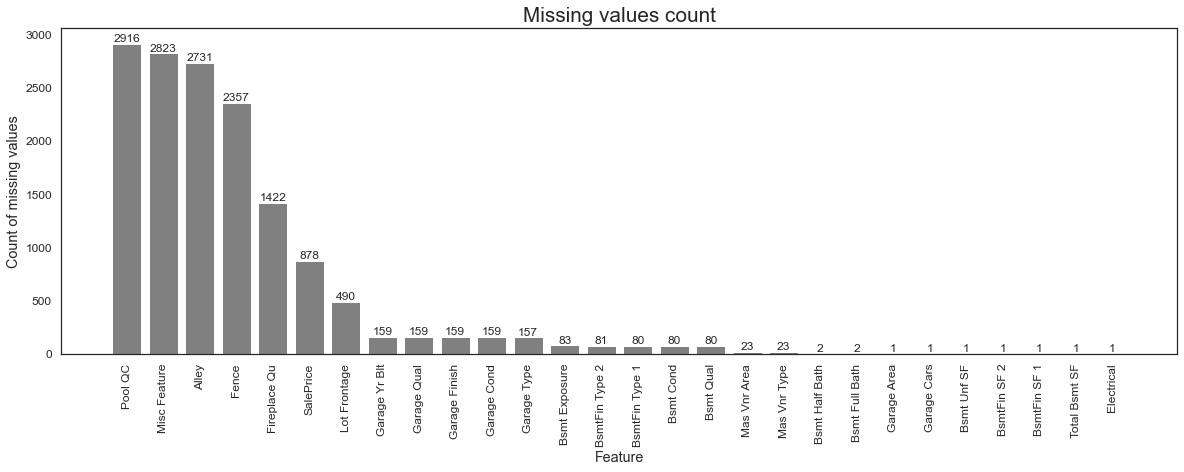

In [1612]:
plot_missing(df_original_combined, plot_type = "count")

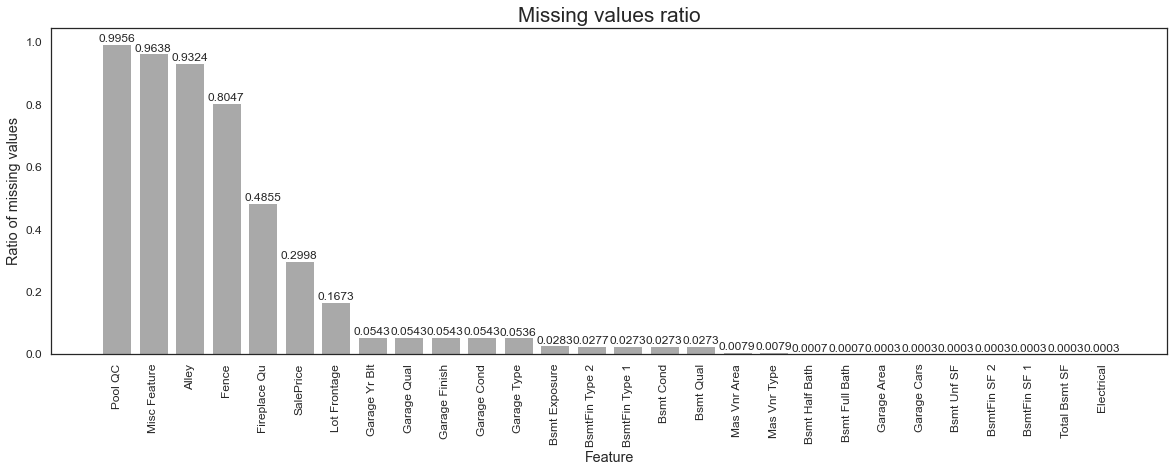

In [1613]:
plot_missing(df_original_combined, plot_type = "ratio")

##### Missing due to absence

For some features, the missing value could result due to the absence of the said feature. Let us investigate if this is indeed the case.

###### Pool QC

For pool, we look to see if the `Pool Area` feature is 0, if it is, it indicates no pool.

In [1614]:
(df_original_combined['Pool Area']==0).sum()

2916

There are 2042 values, same as the missing count of `Pool QC`. We will replace missing values with *NA*

In [1615]:
df_original_combined['Pool QC'].fillna("NA", inplace = True)

Now we perform the same analysis for other missing values

###### Misc Feature

For `Misc Feature`, the data dictionary indicates that NA refers to No misc feature, so we fill the missing values with NA

In [1616]:
df_original_combined['Misc Feature'].value_counts()

Shed    95
Gar2     5
Othr     4
Elev     1
TenC     1
Name: Misc Feature, dtype: int64

In [1617]:
df_original_combined['Misc Feature'].fillna("NA", inplace = True)

###### Alley

For `Alley`, the data dictionary indicates that NA refers to No Alley Access, so we fill the missing values with NA

In [1618]:
# Note that currently NA is null value, so we replace with NA
df_original_combined['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [1619]:
df_original_combined['Alley'].fillna("NA", inplace = True)

###### Fence

Same for `Fence`

In [1620]:
df_original_combined['Fence'].value_counts()

MnPrv    330
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

In [1621]:
df_original_combined['Fence'].fillna("NA", inplace = True)

###### Fireplace Qu

In [1622]:
(df_original_combined['Fireplaces'] == 0).sum()

1422

In [1623]:
df_original_combined['Fireplace Qu'].fillna("NA", inplace = True)

###### Garage

Other than `Garage Type`, other garage related features seem to have same number of missing values, these are probably houses with *no garage*.

We will first take a look at the 2 rows with missing values for other garage features but not `Garage Type`

In [1624]:
(df_original_combined[(df_original_combined['Garage Qual'].isnull()) & (~df_original_combined['Garage Type'].isnull())])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
1712,2237,910201180,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NA,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NA,MnPrv,NA,0,3,2007,WD,150909.0,Train
764,1357,903426160,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NA,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NA,MnPrv,Shed,1000,9,2008,WD,NaN,Test


Seems like these are `Garage Type` with *Detached Garage*.

For the row from training data, we will drop it.

However, we cannot drop the row from test dataframe, so we replace the missing values with 
- "Year Built" for "Garage Yr Blt", since from the plot below, it is likely that the garage will be built when the house is built
- *mode* value of the test dataframe with similar garage type, for the categorical features

,Garage Yr Blt,Year Built
Garage Yr Blt,1.000000,0.834771
Year Built,0.834771,1.000000


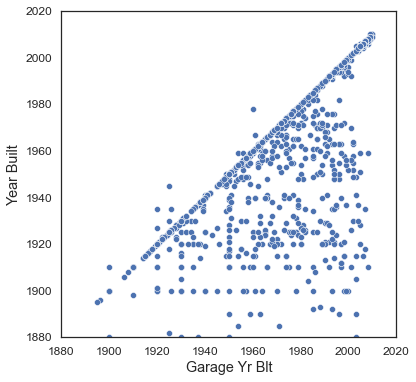

In [1625]:
plt.figure(figsize = (6,6))
sns.scatterplot(data = df_original_combined, x = "Garage Yr Blt", y = "Year Built")
plt.xlim(1880, 2020)
plt.ylim(1880, 2020)
df_original_combined[["Garage Yr Blt", "Year Built"]].corr()

In [1626]:
# Train: Filter out the row with PID
df_original_combined = df_original_combined[~(df_original_combined['PID'] == 910201180)]

In [1627]:
# Test: fillna with either year built or mode
df_original_combined[(df_original_combined['PID'] == 903426160)] = df_original_combined[(df_original_combined['PID'] == 903426160)].fillna({
    "Garage Yr Blt": df_original_combined[(df_original_combined['PID'] == 903426160)]["Year Built"],
    "Garage Finish": df_original_test[df_original_test["Garage Type"] == "Detchd"]["Garage Finish"].mode()[0],
    "Garage Qual": df_original_test[df_original_test["Garage Type"] == "Detchd"]["Garage Qual"].mode()[0],
    "Garage Cond": df_original_test[df_original_test["Garage Type"] == "Detchd"]["Garage Cond"].mode()[0]
})

In [1628]:
df_original_combined[(df_original_combined['PID'] == 903426160)][["Garage Yr Blt", "Garage Qual", "Garage Qual", "Garage Cond"]]

,Garage Yr Blt,Garage Qual,Garage Qual,Garage Cond
764,1910.0,TA,TA,TA


Now we tackle the missing values for garage features with no garage. Similar to previous case, we will fill missing values with relevant values while taking note to prevent leakage by restricting replacement to either statistics from train or test set

In [1629]:
# First we get the PID for the missing garage features so its more convenient to check back
garage_missing_PID = df_original_combined[df_original_combined['Garage Finish'].isnull()]['PID']

In [1630]:
# Fill missing for other garage features
df_original_combined = df_original_combined.fillna({
    "Garage Yr Blt": df_original_combined["Year Built"],
    "Garage Finish": "NA",
    "Garage Qual": "NA",
    "Garage Cond": "NA",
    "Garage Type": "NA"
})

In [1631]:
df_original_combined[df_original_combined['PID'].isin(garage_missing_PID)].head(5)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
28,2243,911103060,190,C (all),75.0,8250,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,2fmCon,2Story,5,6,1895,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,957.0,957.0,GasA,Fa,N,SBrkr,1034,957,0,1991,0.0,0.0,2,0,4,2,TA,9,Typ,0,NA,NA,1895.0,NA,0.0,0.0,NA,NA,N,0,0,133,0,0,0,NA,NA,NA,0,6,2007,WD,119600.0,Train
53,330,923226250,160,RM,21.0,1476,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,176.0,Unf,0.0,370.0,546.0,GasA,Ex,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NA,NA,1970.0,NA,0.0,0.0,NA,NA,Y,200,26,0,0,0,0,NA,NA,NA,0,3,2010,WD,76000.0,Train
65,2278,923202134,20,RL,70.0,8402,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Feedr,Norm,1Fam,1Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,ALQ,206.0,Unf,0.0,914.0,1120.0,GasA,Ex,Y,SBrkr,1120,0,0,1120,0.0,0.0,1,0,3,1,TA,6,Typ,0,NA,NA,2007.0,NA,0.0,0.0,NA,NA,Y,0,30,0,0,0,0,NA,NA,NA,0,12,2007,New,147000.0,Train
79,2235,910201050,50,RM,50.0,7288,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1925,2003,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,Gd,BrkTil,TA,Po,No,Unf,0.0,Unf,0.0,936.0,936.0,GasA,Ex,Y,SBrkr,936,665,0,1601,0.0,0.0,2,0,3,1,TA,6,Typ,0,NA,NA,1925.0,NA,0.0,0.0,NA,NA,N,0,0,0,176,0,0,NA,NA,NA,0,9,2007,WD,129850.0,Train
101,2084,905476170,30,RL,58.0,9098,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,7,1920,2002,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,ALQ,348.0,Unf,0.0,180.0,528.0,GasA,Ex,Y,SBrkr,605,0,0,605,1.0,0.0,1,0,2,1,TA,5,Typ,0,NA,NA,1920.0,NA,0.0,0.0,NA,NA,N,0,0,144,0,0,0,NA,NA,NA,0,7,2007,WD,86000.0,Train


###### Basement

For basement features, there are 3 observations with missing values for *Bsmt Exposure* but not others, let us take a closer look. 

In [1632]:
(df_original_combined[((df_original_combined['Bsmt Exposure'].isnull()) & 
                       (~df_original_combined['Bsmt Cond'].isnull()))])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
1456,1797,528458090,60,FV,81.0,10411,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,CBlock,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,Gd,8,Typ,0,NA,Attchd,2007.0,Unf,2.0,561.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,7,2007,New,212109.0,Train
1547,67,528445060,20,RL,73.0,8987,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,TA,Y,144,0,0,0,0,0,NA,NA,NA,0,5,2010,WD,221500.0,Train
1997,2780,907194130,60,RL,65.0,14006,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,GasA,Ex,Y,SBrkr,936,840,0,1776,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2.0,474.0,TA,TA,Y,144,96,0,0,0,0,NA,NA,NA,0,2,2006,WD,192500.0,Train


Since there are only 3 rows, we will filter out the rows

In [1633]:
df_original_combined = (df_original_combined[~((df_original_combined['Bsmt Exposure'].isnull()) & 
                        (~df_original_combined['Bsmt Cond'].isnull()))])

In [1634]:
df_original_combined.shape

(2925, 82)

For other basement features with missing values, there are missing values, it is because there are no basements, as seen from the 0 values for *Total Bsmt SF* . Let us fill the missing values with NA. 

In [1635]:
# A quick look to see if the basement area is 0 or NaN, which would indicate a lack of basement
df_original_combined[((df_original_combined['Bsmt Qual'].isnull()) & (df_original_combined['Total Bsmt SF'] == 0.0)) | (df_original_combined['Total Bsmt SF'].isnull())].head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
12,807,906226060,70,RL,120.0,26400,Pave,NA,Reg,Bnk,AllPub,FR2,Gtl,SawyerW,Feedr,Norm,1Fam,2Story,5,7,1880,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,1288,728,0,2016,0.0,0.0,1,0,4,1,TA,7,Mod,1,TA,Attchd,1900.0,Unf,2.0,576.0,TA,TA,P,0,0,0,0,0,0,NA,NA,NA,0,6,2009,WD,131000.0,Train
93,811,906226100,90,RL,64.0,7018,Pave,NA,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,1535,0,0,1535,0.0,0.0,2,0,4,2,TA,8,Typ,0,NA,Attchd,1979.0,Unf,2.0,400.0,TA,TA,Y,0,0,0,0,0,0,NA,GdPrv,NA,0,6,2009,WD,118858.0,Train
114,781,905228050,20,RL,NaN,9000,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Norm,Norm,1Fam,1Story,2,2,1947,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Fa,N,SBrkr,660,0,0,660,0.0,0.0,1,0,2,1,Fa,5,Min2,0,NA,NA,1947.0,NA,0.0,0.0,NA,NA,N,0,0,100,0,0,0,NA,NA,NA,0,6,2009,WD,63900.0,Train
146,888,908128060,85,RL,64.0,7301,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,SFoyer,7,5,2003,2003,Gable,CompShg,HdBoard,HdBoard,BrkFace,500.0,Gd,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,495,1427,0,1922,0.0,0.0,3,0,4,1,Gd,7,Typ,1,Ex,BuiltIn,2003.0,RFn,2.0,672.0,TA,TA,Y,0,0,177,0,0,0,NA,NA,NA,0,7,2009,ConLD,198500.0,Train
183,1554,910251050,20,A (agr),80.0,14584,Pave,NA,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Sal,0,NA,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NA,NA,NA,0,2,2008,WD,13100.0,Train


In [1636]:
# Fill missing for other basement features
df_original_combined = df_original_combined.fillna({
    "Bsmt Qual": "NA",
    "Bsmt Cond": "NA",
    "Bsmt Exposure": "NA",
    "BsmtFin Type 1": "NA",
    "BsmtFin Type 2": "NA",
    "BsmtFin SF 1": 0,
    "BsmtFin SF 2": 0,
    "Bsmt Unf SF": 0,
    "Total Bsmt SF": 0,
    "Bsmt Full Bath": 0,
    "Bsmt Half Bath": 0
})

###### Masonry veneer

For Mas Vnr Type and Area, we will impute the missing values as "None" and 0.

In [1637]:
df_original_combined['Mas Vnr Type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn', 'CBlock'], dtype=object)

In [1638]:
# Fill missing for Masonry Veneer features
df_original_combined = df_original_combined.fillna({
    "Mas Vnr Type": "None",
    "Mas Vnr Area": 0,
})

###### Electrical

In [1639]:
# View the missing row for electrical 
df_original_combined[df_original_combined['Electrical'].isnull()]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
634,1578,916386080,80,RL,73.0,9735,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,NaN,754,640,0,1394,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NA,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NA,NA,NA,0,5,2008,WD,NaN,Test


Since this is an observation from the test set, we cannot drop it. Hence, we will fill it with the most frequent occurance. 

In [1640]:
df_original_combined['Electrical'] = df_original_combined['Electrical'].fillna(df_original_combined['Electrical'].mode()[0])

###### Lot frontage

Lot frontage refers to the length of the street directly bordering the property. It is often the case that properties located along the same street have similar lots and styles. Properties located close to each other will have have closer `PID` (Parcel ID). It is also often the case that `Lot Area`, lot shape and `Lot Config` have some influence on the frontage. So we will fit a KNN model using the above mentioned features to predict the missing values for `Lot Frontage`.

(20.0, 160.0)

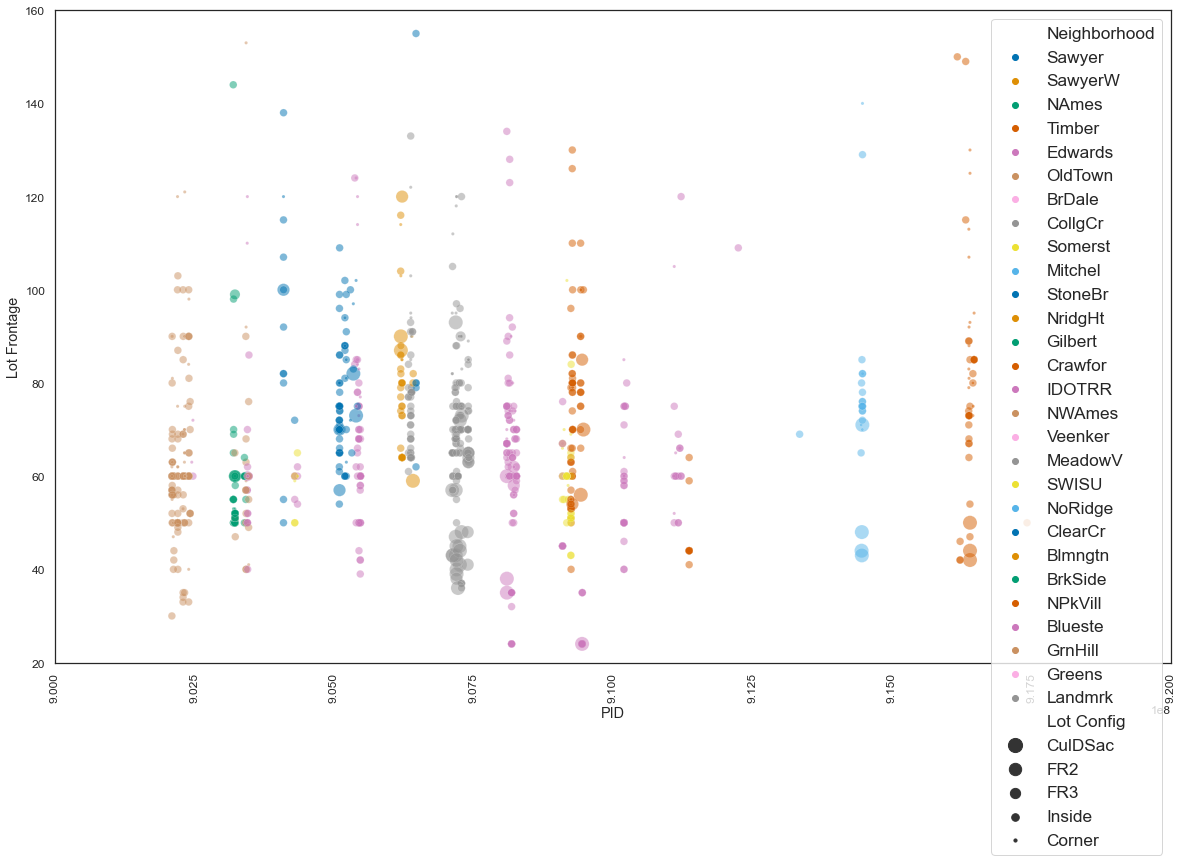

In [1641]:
# See if there is some relation between the features and lot frontage
plt.figure(figsize = (20, 12))
sns.scatterplot(data = df_original_combined, x = 'PID', y = "Lot Frontage", hue = 'Neighborhood', alpha = 0.5, palette = 'colorblind', size = "Lot Config", sizes = (10, 200), size_order = ["CulDSac", "FR2", "FR3", "Inside", "Corner"])
plt.xticks(rotation = 90);
plt.legend(loc = 'upper right')
plt.xlim(900000000, 920000000)
plt.ylim(20, 160)

There seems to some clustering for the observations so we will procced with the predictios base on the logic. 

First we pick out all PIDs of with missing `Lot Frontage` values so its is easier to merge later.

In [1642]:
# Get PID for rows with missing values
PID_fontage_missing = df_original_combined[df_original_combined['Lot Frontage'].isnull()]['PID']

Then we get the features columns for the relevant features.

In [1643]:
# Get a subset of the features we want
df_original_combined_subset = df_original_combined[["PID", "MS SubClass", "Lot Frontage", "Lot Area", "Lot Config", "Neighborhood", "Train/Test"]]

# Get dummy for categorical variables
df_original_combined_subset_dummies = pd.get_dummies(data = df_original_combined_subset, 
                                                     columns = ["MS SubClass", "Lot Config", "Neighborhood"], drop_first=True)
# Divide into train and test to prevent data leakage
df_original_combined_subset_dummies_train = df_original_combined_subset_dummies[df_original_combined_subset_dummies["Train/Test"] == "Train"].drop("Train/Test", axis = 1)
df_original_combined_subset_dummies_test = df_original_combined_subset_dummies[df_original_combined_subset_dummies["Train/Test"] == "Test"].drop("Train/Test", axis = 1)

df_original_combined_subset_dummies_train.head(3)

,PID,Lot Frontage,Lot Area,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,533352170,NaN,13517,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,531379050,43.0,11492,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,535304180,68.0,7922,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [1644]:
# We use a KNN regressor to predict the Lot Frontage
# We will use the nearest 3 neighbors (so there is a higher chance that the properties will be located close together)
# with a weighted component so those properties nearests to the property of interest will have a higher influence on our prediction

# Train 
it_imp = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=3, weights = 'distance'))
it_impt_train = it_imp.fit_transform(df_original_combined_subset_dummies_train)
df_lot_subset_train_predicted = pd.DataFrame(it_impt_train, columns = df_original_combined_subset_dummies_train.columns)

# Test 
it_imp = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=3, weights = 'distance'))
it_impt_test = it_imp.fit_transform(df_original_combined_subset_dummies_test)
df_lot_subset_test_predicted = pd.DataFrame(it_impt_test, columns = df_original_combined_subset_dummies_test.columns)

In [1645]:
# Combine train and test 
df_lot_subset_predicted = pd.concat([df_lot_subset_train_predicted, df_lot_subset_test_predicted])

# Replace with predicted values
df_original_combined_no_missing = df_original_combined.copy()
df_original_combined_no_missing["Lot Frontage"] = df_lot_subset_predicted["Lot Frontage"].values

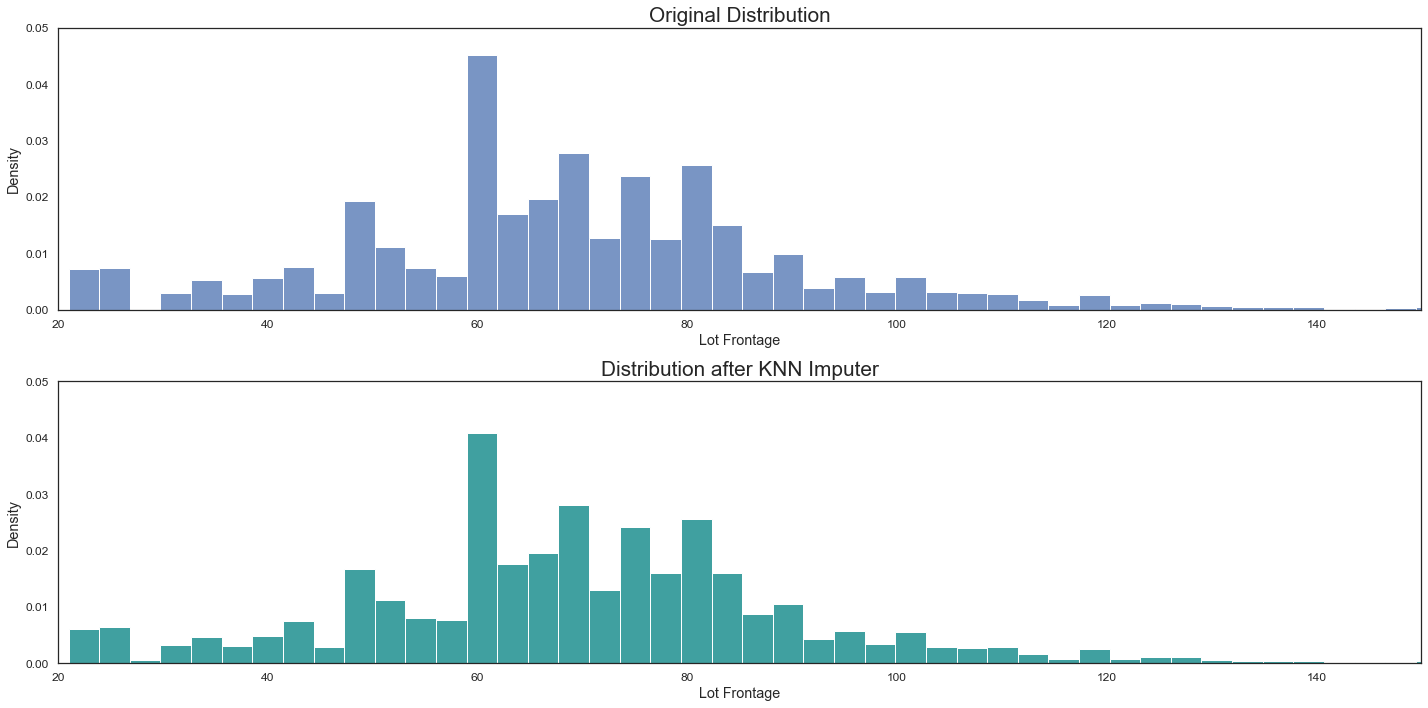

In [1646]:
# Plot the distribution before and after using imputer
plt.figure(figsize = (20, 10))
ax1 = plt.subplot(211)
sns.histplot(df_original_combined["Lot Frontage"], stat = 'density', bins = 100)
plt.xlim(20, 150)
plt.ylim(0, 0.05)
plt.title("Original Distribution")

ax2 = plt.subplot(212)
sns.histplot(df_original_combined_no_missing["Lot Frontage"], stat = 'density', bins = 100, color = "teal")
plt.xlim(20, 150)
plt.ylim(0, 0.05)
plt.title("Distribution after KNN Imputer")

plt.tight_layout();

We see that the distibutions are almost identical before and after imputing with KNNRegressor.

We have now dealt with all missing values

### Feature Engineering

Let us view the current dataframe

In [1647]:
print(df_original_combined_no_missing.shape)
df_original_combined_no_missing

(2925, 82)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
0,109,533352170,60,RL,97.621342,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NA,NA,NA,0,3,2010,WD,130500.0,Train
1,544,531379050,60,RL,43.000000,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NA,NA,NA,0,4,2009,WD,220000.0,Train
2,153,535304180,20,RL,68.000000,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NA,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NA,NA,NA,0,1,2010,WD,109000.0,Train
3,318,916386060,60,RL,73.000000,9802,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NA,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,174000.0,Train
4,255,906425045,50,RL,82.000000,14235,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NA,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NA,NA,NA,0,3,2010,WD,138500.0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,2919,923228210,160,RM,21.000000,1526,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NA,NA,1970.0,NA,0.0,0.0,NA,NA,Y,0,34,0,0,0,0,NA,GdPrv,NA,0,6,2006,WD,NaN,Test
178,2921,923228310,160,RM,21.000000,1894,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NA,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NA,NA,NA,0,4,2006,WD,NaN,Test
828,2922,923229110,90,RL,55.000000,12640,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,6,5,1976,1976,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,Rec,936.0,LwQ,396.0,396.0,1728.0,GasA,TA,Y,SBrkr,1728,0,0,1728,0.0,0.0,2,0,4,

#### Encoding Ordinal Variables

Some features consists of values which indicate some form of order, these are mainly features that place some form of judgement on the condition/quality. There is also `Central Air` features with 2 values indicating the presence or absence of central air.

In [1648]:
encode_features_cols = ['Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond',
                    'Heating QC','Kitchen Qual','Garage Qual','Garage Cond','Pool QC','Fireplace Qu', 
                    'Central Air', 'Functional']

# View unique values
for col in encode_features_cols:
    print(col, ": ", df_original_combined_no_missing[col].unique())

Overall Qual :  [ 6  7  5  8 10  4  9  3  2  1]
Overall Cond :  [8 5 7 6 3 9 2 4 1]
Exter Qual :  ['Gd' 'TA' 'Ex' 'Fa']
Exter Cond :  ['TA' 'Gd' 'Fa' 'Ex' 'Po']
Bsmt Qual :  ['TA' 'Gd' 'Fa' 'NA' 'Ex' 'Po']
Bsmt Cond :  ['TA' 'Gd' 'NA' 'Fa' 'Po' 'Ex']
Heating QC :  ['Ex' 'TA' 'Gd' 'Fa' 'Po']
Kitchen Qual :  ['Gd' 'TA' 'Fa' 'Ex' 'Po']
Garage Qual :  ['TA' 'Fa' 'NA' 'Gd' 'Ex' 'Po']
Garage Cond :  ['TA' 'Fa' 'NA' 'Po' 'Gd' 'Ex']
Pool QC :  ['NA' 'Fa' 'Gd' 'Ex' 'TA']
Fireplace Qu :  ['NA' 'TA' 'Gd' 'Po' 'Ex' 'Fa']
Central Air :  ['Y' 'N']
Functional :  ['Typ' 'Mod' 'Min2' 'Maj1' 'Min1' 'Sev' 'Sal' 'Maj2']


In [1649]:
df_original_combined_no_missing.replace({
    "Exter Qual":{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Exter Cond":{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Bsmt Qual":{'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Bsmt Cond":{'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Heating QC":{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Kitchen Qual":{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Garage Qual":{'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Garage Cond":{'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Pool QC":{'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Fireplace Qu":{'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    "Central Air": {"N": 0,"Y": 1},
    "Functional": {'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8}
},inplace=True)

#### Changing Year to Age

Instead of using year `Year Built` and `Year Remod/Add`, we could get the `Age Since Built` and `Age Since Remod`. Let us first see if the year features has any anomalies.

In [1650]:
# The Ames dataset was taken in 2011, so any date later than that would not make sense

# Year Sold
print("Yr Sold:", df_original_combined_no_missing[df_original_combined_no_missing['Yr Sold']>2011].shape)
print("Yr Sold - Earliest: ", df_original_combined_no_missing['Yr Sold'].min())
# Year Built
print("Year Built:", df_original_combined_no_missing[df_original_combined_no_missing['Year Built']>2011].shape)
print("Year Built - Earliest: ", df_original_combined_no_missing['Year Built'].min())
# Year Remod/Add
print("Year Remod/Add:", df_original_combined_no_missing[df_original_combined_no_missing['Year Remod/Add']>2011].shape)
print("Year Remod/Add - Earliest: ", df_original_combined_no_missing['Year Remod/Add'].min())
# Garage Yr Blt
print("Garage Yr Blt:", df_original_combined_no_missing[df_original_combined_no_missing['Garage Yr Blt']>2011].shape)
print("Garage Yr Blt - Earliest: ", df_original_combined_no_missing['Garage Yr Blt'].min())

Yr Sold: (0, 82)
Yr Sold - Earliest:  2006
Year Built: (0, 82)
Year Built - Earliest:  1872
Year Remod/Add: (0, 82)
Year Remod/Add - Earliest:  1950
Garage Yr Blt: (1, 82)
Garage Yr Blt - Earliest:  1872.0


In [1651]:
# We have one instance of Garage Yr Blt later than 2011
df_original_combined_no_missing[df_original_combined_no_missing['Garage Yr Blt']>2011]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
1699,2261,916384070,20,RL,68.0,8298,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,4,3,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,5,1,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,5,6,8,1,4,Attchd,2207.0,RFn,2.0,502.0,3,3,Y,132,0,0,0,0,0,0,NA,NA,0,9,2007,New,267300.0,Train


In [1652]:
# We will replace the Garage Yr Blt with with the Year Blt
df_original_combined_no_missing = df_original_combined_no_missing.replace({"Garage Yr Blt": {2207.0:2006}})

In [1653]:
df_original_combined_no_missing[df_original_combined_no_missing['Garage Yr Blt']>2011]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test


We have now dealt with the issue with Garage Yr Blt. Let us see if there are remod year which are earlier than built year, which would not make sense as well. 

In [1654]:
df_original_combined_no_missing[df_original_combined_no_missing["Year Remod/Add"] < df_original_combined_no_missing["Year Built"]]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
1003,851,907194160,20,RL,65.0,10739,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2002,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,68.0,4,3,PConc,4,3,No,GLQ,1259.0,Unf,0.0,172.0,1431.0,GasA,5,1,SBrkr,1444,0,0,1444,1.0,0.0,2,0,3,1,4,6,8,0,0,Attchd,2002.0,RFn,2.0,577.0,3,3,Y,144,40,0,0,0,0,0,NA,NA,0,4,2009,WD,203000.0,Train


There is one such case, we will change Year Built to 2001.

In [1655]:
df_original_combined_no_missing[df_original_combined_no_missing["PID"] == 907194160] = df_original_combined_no_missing[df_original_combined_no_missing["PID"] == 907194160].replace({"Year Built":{2002:2001}})

In [1656]:
df_original_combined_no_missing[df_original_combined_no_missing["PID"] == 907194160]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test
1003,851,907194160,20,RL,65.0,10739,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,68.0,4,3,PConc,4,3,No,GLQ,1259.0,Unf,0.0,172.0,1431.0,GasA,5,1,SBrkr,1444,0,0,1444,1.0,0.0,2,0,3,1,4,6,8,0,0,Attchd,2002.0,RFn,2.0,577.0,3,3,Y,144,40,0,0,0,0,0,NA,NA,0,4,2009,WD,203000.0,Train


We will create the new feature columns for age now.

In [1657]:
df_original_combined_no_missing["Age Since Built"] = df_original_combined_no_missing["Yr Sold"] - df_original_combined_no_missing["Year Built"]
df_original_combined_no_missing["Age Since Remod/Add"] = df_original_combined_no_missing["Yr Sold"] - df_original_combined_no_missing["Year Remod/Add"]

In [1658]:
df_original_combined_no_missing.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test,Age Since Built,Age Since Remod/Add
0,109,533352170,60,RL,97.621342,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,CBlock,3,3,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,5,1,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,8,0,0,Attchd,1976.0,RFn,2.0,475.0,3,3,Y,0,44,0,0,0,0,0,NA,NA,0,3,2010,WD,130500.0,Train,34,5
1,544,531379050,60,RL,43.000000,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,4,3,PConc,4,3,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,5,1,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,8,1,3,Attchd,1997.0,RFn,2.0,559.0,3,3,Y,0,74,0,0,0,0,0,NA,NA,0,4,2009,WD,220000.0,Train,13,12
2,153,535304180,20,RL,68.000000,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3,3,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,3,1,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,8,0,0,Detchd,1953.0,Unf,1.0,246.0,3,3,Y,0,52,0,0,0,0,0,NA,NA,0,1,2010,WD,109000.0,Train,57,3


We shall do some visualizatio for the year and age features with the saleprice.

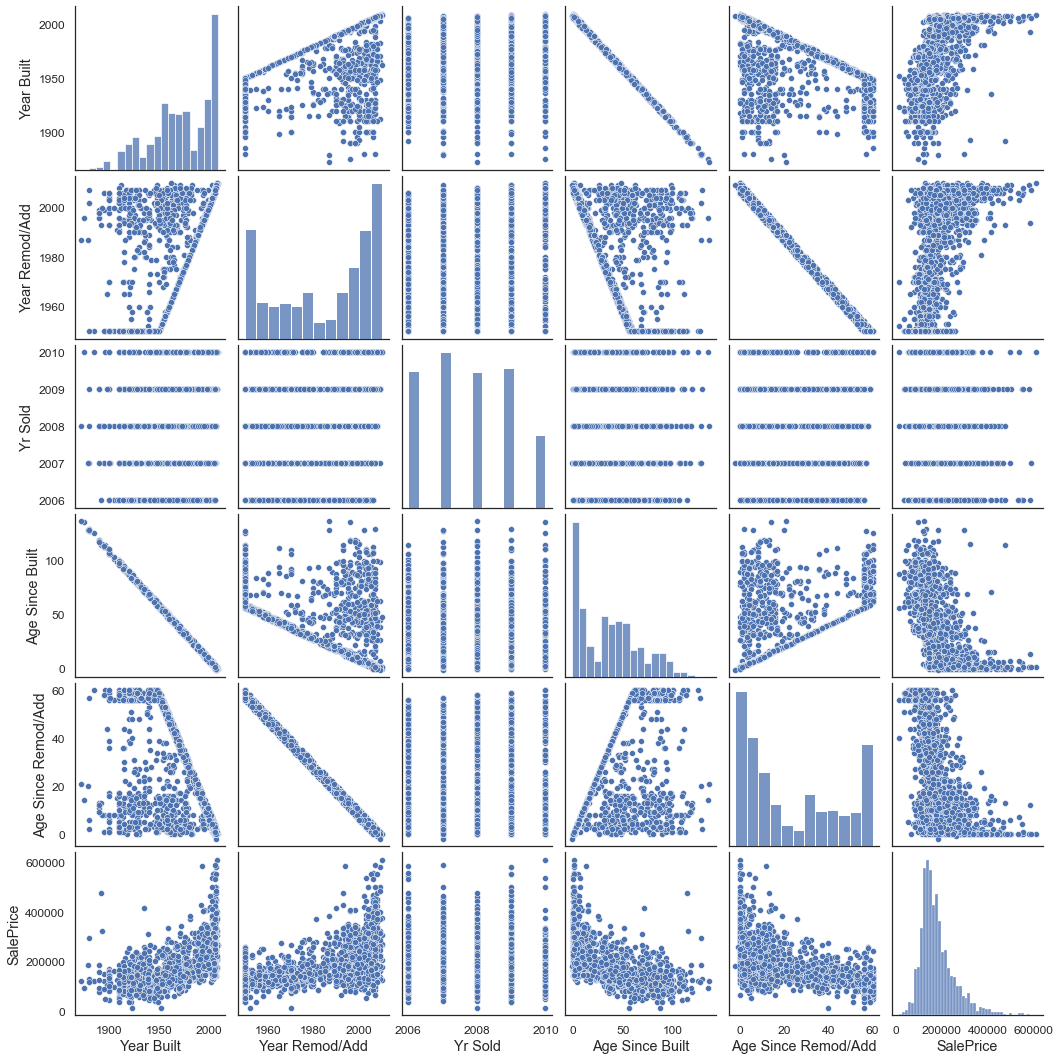

In [1659]:
df_original_train_no_missing = df_original_combined_no_missing[df_original_combined_no_missing["Train/Test"] == "Train"] 
sns.pairplot(df_original_train_no_missing[["Year Built", "Year Remod/Add", "Yr Sold", "Age Since Built", "Age Since Remod/Add", "SalePrice"]])

In [1660]:
df_original_train_no_missing[["Year Built", "Year Remod/Add", "Yr Sold", "Age Since Built", "Age Since Remod/Add", "SalePrice"]].corr()

,Year Built,Year Remod/Add,Yr Sold,Age Since Built,Age Since Remod/Add,SalePrice
Year Built,1.000000,0.629560,-0.003963,-0.999056,-0.630274,0.571934
Year Remod/Add,0.629560,1.000000,0.043056,-0.626987,-0.998056,0.550527
Yr Sold,-0.003963,0.043056,1.000000,0.047395,0.019298,-0.015551
Age Since Built,-0.999056,-0.626987,0.047395,1.000000,0.630409,-0.571972
Age Since Remod/Add,-0.630274,-0.998056,0.019298,0.630409,1.000000,-0.551906
SalePrice,0.571934,0.550527,-0.015551,-0.571972,-0.551906,1.000000


We see that Age features has a slighly better correlation value compared to Year features. They also have the advantage of being a derivation of Sold and Built years. Therefore, we will drop the `Year Built` and `Year Remod/Add`. However, we will keep the `Yr Sold` feature as they may account for yearly sale price fluctuations. Even from the visualization, we see that there was a price drop in 2008 which may have been the 2008 recession.

In [1661]:
print(df_original_combined_no_missing.shape)
#df_original_combined_no_missing.drop(["Year Built", "Year Remod/Add"], axis = 1, inplace = True)

# We will create a list which holds the features to drop
features_to_drop = ["Year Built", "Year Remod/Add"]

(2925, 84)


In [1662]:
df_original_combined_no_missing.shape

(2925, 84)

#### Combine Features

We could combine the number of bathrooms to produce a feature call `Total Bath`

In [1663]:
df_original_combined_no_missing['Total Bath'] = (df_original_combined_no_missing['Bsmt Full Bath'] + 
                                              df_original_combined_no_missing['Bsmt Half Bath'] +
                                             df_original_combined_no_missing['Full Bath']+ 
                                             df_original_combined_no_missing['Half Bath'])

We will also add a `Gross Flr Area` feature which is the sum of `Total Bsmt SF` and `Gr Liv Area`

In [1664]:
df_original_combined_no_missing['Gross Flr Area'] = (df_original_combined_no_missing['Total Bsmt SF'] + 
                                              df_original_combined_no_missing['Gr Liv Area'])

#### Additional features to indicate presence of housing components 

We will add some additional features which just contains boolean values to indicate the presence (1) or absence (0) of certain housing components like fireplace, pool, etc.

In [1665]:
df_original_combined_no_missing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test,Age Since Built,Age Since Remod/Add,Total Bath,Gross Flr Area
0,109,533352170,60,RL,97.621342,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,CBlock,3,3,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,5,1,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,8,0,0,Attchd,1976.0,RFn,2.0,475.0,3,3,Y,0,44,0,0,0,0,0,NA,NA,0,3,2010,WD,130500.0,Train,34,5,3.0,2204.0
1,544,531379050,60,RL,43.000000,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,4,3,PConc,4,3,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,5,1,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,8,1,3,Attchd,1997.0,RFn,2.0,559.0,3,3,Y,0,74,0,0,0,0,0,NA,NA,0,4,2009,WD,220000.0,Train,13,12,4.0,3035.0
2,153,535304180,20,RL,68.000000,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3,3,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,3,1,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,8,0,0,Detchd,1953.0,Unf,1.0,246.0,3,3,Y,0,52,0,0,0,0,0,NA,NA,0,1,2010,WD,109000.0,Train,57,3,2.0,2114.0
3,318,916386060,60,RL,73.000000,9802,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,4,1,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,3,7,8,0,0,BuiltIn,2007.0,Fin,2.0,400.0,3,3,Y,100,0,0,0,0,0,0,NA,NA,0,4,2010,WD,174000.0,Train,4,3,3.0,1828.0
4,255,906425045,50,RL,82.000000,14235,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,PConc,2,4,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,3,1,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,3,6,8,0,0,Detchd,1957.0,Unf,2.0,484.0,3,3,N,0,59,0,0,0,0,0,NA,NA,0,3,2010,WD,138500.0,Train,110,17,2.0,2121.0


In [1666]:
# Function to indicate if a housing component is present 
def feature_presence(row):
    housing_components = {"Mas Vnr Type": "Has Mas Vnr", "Bsmt Exposure": "Has Basement", 
                          "Garage Type": "Has Garage", "Wood Deck SF": "Has Wood Deck",
                         "Open Porch SF": "Has Open Porch", "3Ssn Porch": "Has 3Ssn Porch",
                         "Screen Porch": "Has Screen Porch", "Pool Area": "Has Pool",
                         "2nd Flr SF": "Has 2nd Flr"}
    for key in housing_components.keys():
        if row[key] == "NA" or row[key] == "None" or row[key] == 0: # if indicator column is either 'None', 'NA' or 0, then the component is not present
            row[housing_components[key]] = 0
        else:
            row[housing_components[key]] = 1
    return row

df_original_combined_no_missing = df_original_combined_no_missing.apply(feature_presence, axis = 1)

In [1667]:
print(df_original_combined_no_missing.shape)
df_original_combined_no_missing.head()

(2925, 95)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Train/Test,Age Since Built,Age Since Remod/Add,Total Bath,Gross Flr Area,Has Mas Vnr,Has Basement,Has Garage,Has Wood Deck,Has Open Porch,Has 3Ssn Porch,Has Screen Porch,Has Pool,Has 2nd Flr
0,109,533352170,60,RL,97.621342,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,CBlock,3,3,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,5,1,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,8,0,0,Attchd,1976.0,RFn,2.0,475.0,3,3,Y,0,44,0,0,0,0,0,NA,NA,0,3,2010,WD,130500.0,Train,34,5,3.0,2204.0,1,1,1,0,1,0,0,0,1
1,544,531379050,60,RL,43.000000,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,4,3,PConc,4,3,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,5,1,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,8,1,3,Attchd,1997.0,RFn,2.0,559.0,3,3,Y,0,74,0,0,0,0,0,NA,NA,0,4,2009,WD,220000.0,Train,13,12,4.0,3035.0,1,1,1,0,1,0,0,0,1
2,153,535304180,20,RL,68.000000,7922,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,3,3,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,3,1,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,8,0,0,Detchd,1953.0,Unf,1.0,246.0,3,3,Y,0,52,0,0,0,0,0,NA,NA,0,1,2010,WD,109000.0,Train,57,3,2.0,2114.0,0,1,1,0,1,0,0,0,0
3,318,916386060,60,RL,73.000000,9802,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,4,1,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,3,7,8,0,0,BuiltIn,2007.0,Fin,2.0,400.0,3,3,Y,100,0,0,0,0,0,0,NA,NA,0,4,2010,WD,174000.0,Train,4,3,3.0,1828.0,0,1,1,1,0,0,0,0,1
4,255,906425045,50,RL,82.000000,14235,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,3,3,PConc,2,4,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,3,1,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,3,6,8,0,0,Detchd,1957.0,Unf,2.0,484.0,3,3,N,0,59,0,0,0,0,0,NA,NA,0,3,2010,WD,138500.0,Train,110,17,2.0,2121.0,0,1,1,0,1,0,0,0,1


### Feature Selection

#### Separating Feature Types

We will separate the features into **Numeric**, **Ordinal**, **Categorical** and **Non-Useful (such as Id)** features and use different methods for processing and selection.

In [1668]:
# Non-useful predictor
not_useful_features = ["Id", "Train/Test"]

# Categorical predictors
categorical_features = list(df_original_combined_no_missing.select_dtypes(include = "object").columns)
categorical_features.remove('Train/Test')
categorical_features = categorical_features + ["MS SubClass", 'Yr Sold', 'Mo Sold']

# Ordinal predictors - we will place boolean predictors here too since the operations are the same
ordinal_boolean_features = df_original_combined_no_missing.select_dtypes(include = ["float64", "int64"])
ordinal_boolean_features = [col for col in ordinal_boolean_features.columns if len(df_original_combined_no_missing[col].unique()) <15]
ordinal_boolean_features = list(set(ordinal_boolean_features) - set(categorical_features))
ordinal_remove_boolean = ['Bsmt Full Bath', 'Half Bath', 'Garage Cars', 'Fireplaces', 'TotRms AbvGrd',
                 'Full Bath', 'Total Bath', 'Kitchen AbvGr','Bsmt Half Bath', 'Pool Area', 'Bedroom AbvGr']
ordinal_boolean_features = [feature for feature in ordinal_boolean_features if feature not in ordinal_remove_boolean]
ordinal_boolean_features

# Numeric predictors
# All features not in other lists
numeric_features = [feature for feature in df_original_combined_no_missing.columns 
                    if feature not in not_useful_features and feature not in categorical_features and feature not in ordinal_boolean_features]

#### Numeric Features

In [1669]:
df_original_train_no_missing[["BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "SalePrice"]].corr()

,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,SalePrice
BsmtFin SF 1,1.000000,-0.050516,-0.471969,0.540053,0.424732
BsmtFin SF 2,-0.050516,1.000000,-0.231023,0.086778,0.016527
Bsmt Unf SF,-0.471969,-0.231023,1.000000,0.419629,0.190388
Total Bsmt SF,0.540053,0.086778,0.419629,1.000000,0.629516
SalePrice,0.424732,0.016527,0.190388,0.629516,1.000000


##### Features with weak correlation to response and a high percentage of a single value

We now take a look at the relationship between numeric features and look for possible multicollinearity and features with weak correlations to Sale Price.

In [1670]:
# The threshold to qualify as low correlation
corr_response_threshold = 0.1

In [1671]:
numeric_df_train = df_original_combined_no_missing[df_original_combined_no_missing["Train/Test"] == "Train"][numeric_features]
numeric_df_train.head()

,PID,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Age Since Built,Age Since Remod/Add,Total Bath,Gross Flr Area
0,533352170,97.621342,13517,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,1976.0,2.0,475.0,0,44,0,0,0,0,0,130500.0,34,5,3.0,2204.0
1,531379050,43.000000,11492,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,1997.0,2.0,559.0,0,74,0,0,0,0,0,220000.0,13,12,4.0,3035.0
2,535304180,68.000000,7922,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1953.0,1.0,246.0,0,52,0,0,0,0,0,109000.0,57,3,2.0,2114.0
3,916386060,73.000000,9802,2006,2007,0.0,0.0,0.0,384.0,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,2007.0,2.0,400.0,100,0,0,0,0,0,0,174000.0,4,3,3.0,1828.0
4,906425045,82.000000,14235,1900,1993,0.0,0.0,0.0,676.0,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,1957.0,2.0,484.0,0,59,0,0,0,0,0,138500.0,110,17,2.0,2121.0


In [1672]:
numeric_train_corr = numeric_df_train.corr()

# See which ones are above -0.1 or below 0.1, which would indicate weak correlation
weak_corr = numeric_train_corr[(numeric_train_corr>=-corr_response_threshold) & (numeric_train_corr<= corr_response_threshold)]["SalePrice"].dropna(how = 'all').index

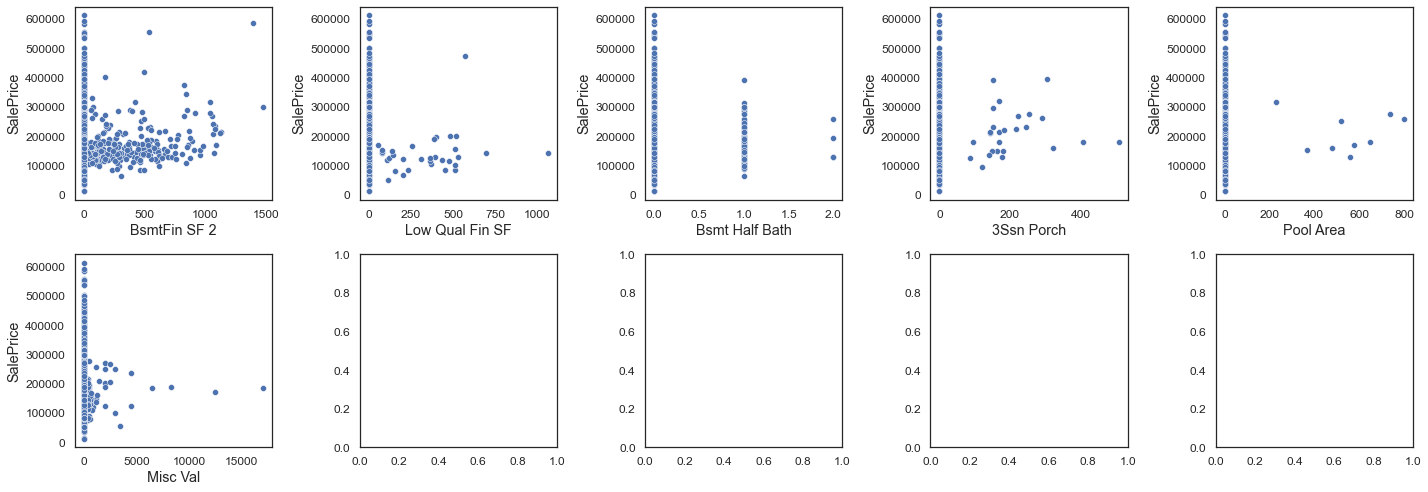

In [1673]:
# Plot scatterplot for weakly correlated features
plot_scatterplot(numeric_df_train, weak_corr, "SalePrice")

Seems like some features has majority of the values of 0. We will see what percentage of each feature has 0 value.

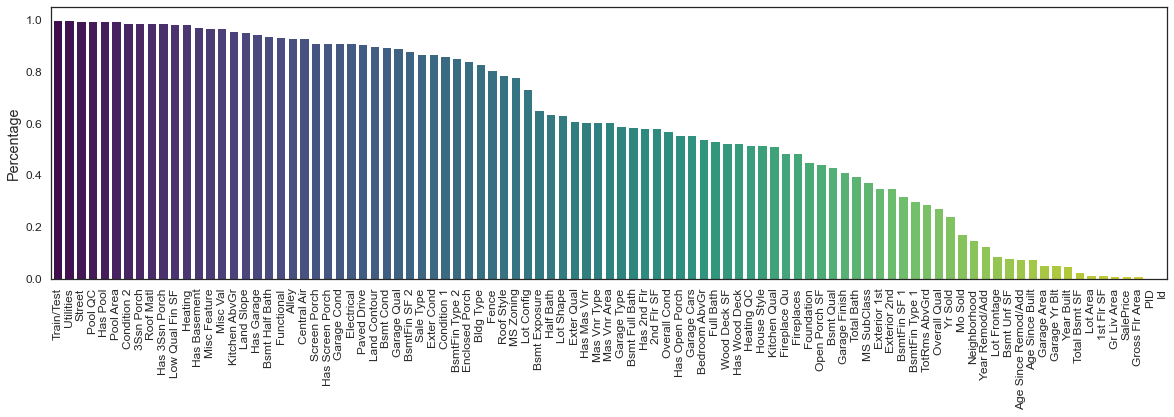

In [1674]:
# View training data value percentage
df_original_train_no_missing = df_original_combined_no_missing[df_original_combined_no_missing["Train/Test"] == "Train"]

plt.figure(figsize = (20,5))
percentage_bar = sns.barplot(x = single_value_percentage(df_original_train_no_missing).index, 
            y = single_value_percentage(df_original_train_no_missing)["Percentage"], palette="viridis")
plt.xticks(rotation = 90);
#plt.bar_label(percentage_bar);

We will pick out features with a weak correlation (-0.1 < r 0.1) and a high percentage of a single value (>90%).

In [1675]:
dominant_feature_threhold = 0.9

In [1676]:
# List of features with high single value items (>0.9)
high_single_value_list = single_value_percentage(df_original_train_no_missing)[single_value_percentage(df_original_train_no_missing)["Percentage"] > dominant_feature_threhold].index

# pick out features with a weak correlation (-0.1 <r 0.1) and a high percentage of a single value (>90%).
weak_corr_single_val = list((high_single_value_list) & (weak_corr))
weak_corr_single_val

['Pool Area', '3Ssn Porch', 'Low Qual Fin SF', 'Misc Val', 'Bsmt Half Bath']

###### Features to drop using different thresholds

In [1677]:
# Generate different feature sets to drop depending on threhold

# Feature set 1 - corr_threshold = 0.1, dominant_feature_threshold = 0.9
features_to_drop1 = numeric_features_to_drop_by_threshold(numeric_df = numeric_df_train, corr_threshold = 0.1, dominant_feature_threshold = 0.9)
features_to_drop1 = list(set(features_to_drop + features_to_drop1))
print("Num of features: ", len(features_to_drop1))

# Feature set 2 - corr_threshold = 0.2, dominant_feature_threshold = 0.9
features_to_drop2 = numeric_features_to_drop_by_threshold(numeric_df = numeric_df_train, corr_threshold = 0.2, dominant_feature_threshold = 0.9)
features_to_drop2 = list(set(features_to_drop + features_to_drop2))
print("Num of features: ", len(features_to_drop2))

# Feature set 3 - corr_threshold = 0.2, dominant_feature_threshold = 0.8
features_to_drop3 = numeric_features_to_drop_by_threshold(numeric_df = numeric_df_train, corr_threshold = 0.2, dominant_feature_threshold = 0.8)
features_to_drop3 = list(set(features_to_drop + features_to_drop3))
print("Num of features: ", len(features_to_drop3))

Num of features:  7
Num of features:  9
Num of features:  11


We have generated 3 features sets (for features to drop)  by setting different threshold values. 

##### Features with high multicollinearity

We will use a correlation value of >0.8 or <-0.8 as threshold for high multicollinearity. 

In [1678]:
# Change this value to set threshold
multicol_threshold = 0.8

In [1679]:
# Get list of features with corr values which falls within our condition 
df_train_corr = numeric_df_train.corr() 
df_train_corr_nulls = df_train_corr[(df_train_corr > multicol_threshold) | (df_train_corr < -multicol_threshold)] # df with correlation values by condition
multicol_features = list((df_train_corr_nulls.notna().sum()[(df_train_corr_nulls.notna().sum() >1)]).index)
multicol_features.append("SalePrice")

<AxesSubplot:>

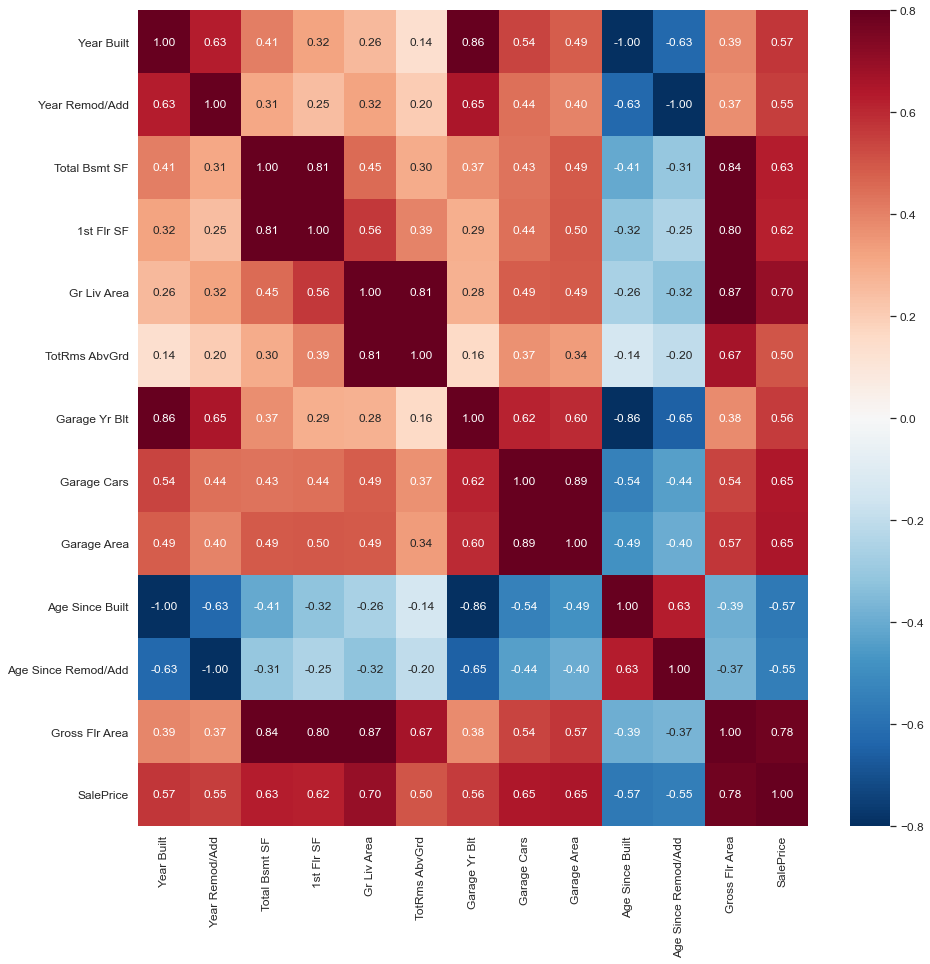

In [1680]:
plt.figure(figsize = (15, 15))
sns.heatmap(numeric_df_train[multicol_features].corr(), cmap="RdBu_r", annot = True, fmt = ".2f",
           vmin = -multicol_threshold, vmax = multicol_threshold)

In [1681]:
# Get a dictionary of features with their respective correlated features
multicollinear_dict = {}
df_train_corr_multicol = numeric_df_train[multicol_features].drop("SalePrice", axis = 1).corr()

# drop the column itself
for col in df_train_corr_multicol.columns:
    correlated_features = list(df_train_corr_multicol[col][((df_train_corr_multicol[col]>multicol_threshold) | (df_train_corr_multicol[col]<-multicol_threshold))].index)
    correlated_features.remove(col)
    multicollinear_dict[col] = correlated_features

In [1682]:
# To get a set of unique feature pairs in order to examine further
feature_pair_remove_dup = []
for feature, corr_feature_list in multicollinear_dict.items():
    for corr_feature in corr_feature_list:
        feature_pair = frozenset([feature, corr_feature])
        feature_pair_remove_dup.append(feature_pair)
#set(feature_pair_remove_dup)
feature_pair_remove_dup = set(feature_pair_remove_dup) # to get unique pairs
feature_pair_remove_dup = [list(frozen_set) for frozen_set in feature_pair_remove_dup]

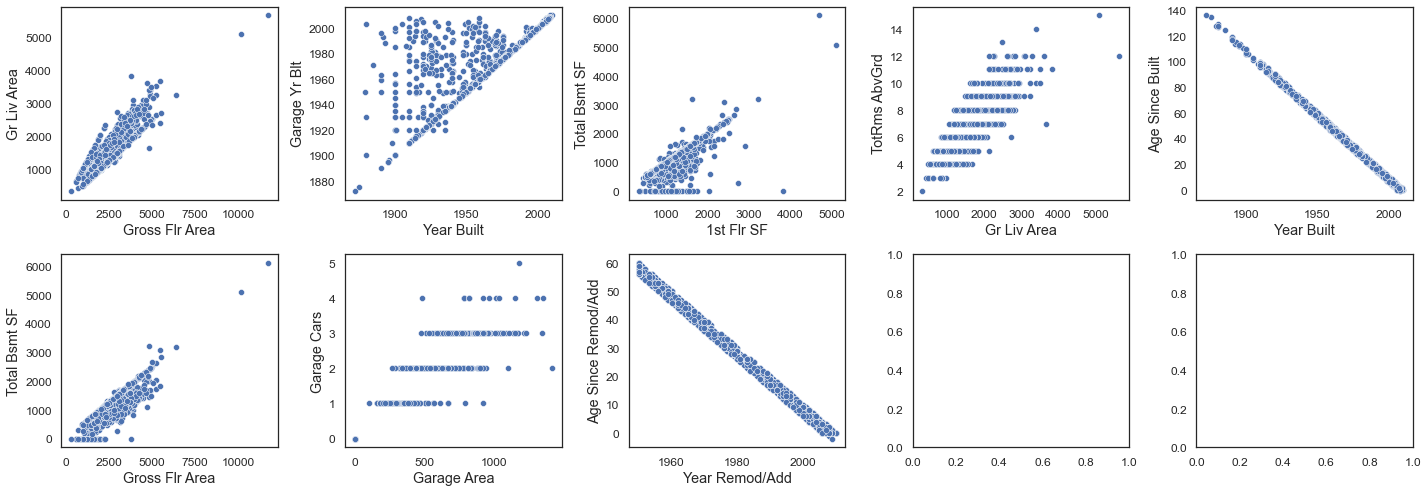

In [1683]:
plot_scatterplot_pairs(numeric_df_train, feature_pair_remove_dup)

Looking at the scatter plots, we will add additional features to the list of features to be dropped.
 - Garage Cars and TotRms AbvGrd
     - These are features with corresponding areas, since the area features are continuous, we will drop these two instead

In [1684]:
features_to_drop1 = list(set(features_to_drop1 + ["Garage Cars", "TotRms AbvGrd"]))
features_to_drop2 = list(set(features_to_drop2 + ["Garage Cars", "TotRms AbvGrd"]))
features_to_drop3 = list(set(features_to_drop3 + ["Garage Cars", "TotRms AbvGrd"]))

In [1685]:
print(len(features_to_drop1))
print(len(features_to_drop2))
print(len(features_to_drop3))

9
11
13


##### Numeric features which are derived from other features

Some features such as basement areas, living areas and number of bathrooms, have a sum total features which are derived from other features, we fit them through a simple model and see if the features are significant.

In [1686]:
numeric_df_train.head()

,PID,Lot Frontage,Lot Area,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Age Since Built,Age Since Remod/Add,Total Bath,Gross Flr Area
0,533352170,97.621342,13517,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,1976.0,2.0,475.0,0,44,0,0,0,0,0,130500.0,34,5,3.0,2204.0
1,531379050,43.000000,11492,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,1997.0,2.0,559.0,0,74,0,0,0,0,0,220000.0,13,12,4.0,3035.0
2,535304180,68.000000,7922,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1953.0,1.0,246.0,0,52,0,0,0,0,0,109000.0,57,3,2.0,2114.0
3,916386060,73.000000,9802,2006,2007,0.0,0.0,0.0,384.0,384.0,744,700,0,1444,0.0,0.0,2,1,3,1,7,0,2007.0,2.0,400.0,100,0,0,0,0,0,0,174000.0,4,3,3.0,1828.0
4,906425045,82.000000,14235,1900,1993,0.0,0.0,0.0,676.0,676.0,831,614,0,1445,0.0,0.0,2,0,3,1,6,0,1957.0,2.0,484.0,0,59,0,0,0,0,0,138500.0,110,17,2.0,2121.0


In [1687]:
basement_areas_features = ["BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF"]
gr_areas_features = ["1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area"]
num_baths_features = ["Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Total Bath"]
all_area_features = basement_areas_features + gr_areas_features + ["Gross Flr Area"]

In [1688]:
all_area_features

['BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Gross Flr Area']

In [1689]:
# Run the 3 sets of features through OLS to determine p value
ols_test_features = [basement_areas_features, gr_areas_features, num_baths_features, all_area_features]
for features in ols_test_features:
    ss = StandardScaler()
    X_scaled = ss.fit_transform(numeric_df_train[features])
    X_scaled_sm = sm.add_constant(X_scaled)
    y = numeric_df_train["SalePrice"]
    ols = sm.OLS(y, X_scaled_sm).fit()
    print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     467.7
Date:                Tue, 01 Feb 2022   Prob (F-statistic):          2.68e-231
Time:                        21:38:04   Log-Likelihood:                -25462.
No. Observations:                2047   AIC:                         5.093e+04
Df Residuals:                    2043   BIC:                         5.095e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.814e+05   1350.963    134.308      0.0

From the p-values, we see that most of the features we tested are significant, with the exception of `Bsmt Unf SF` with a p-value of 11.7%, we will drop this feature.

In [1690]:
features_to_drop1 = list(set(features_to_drop1 + ["Bsmt Unf SF", "BsmtFin SF 2"]))
features_to_drop2 = list(set(features_to_drop2 + ["Bsmt Unf SF", "BsmtFin SF 2"]))
features_to_drop3 = list(set(features_to_drop3 + ["Bsmt Unf SF", "BsmtFin SF 2"]))

In [1691]:
print(len(features_to_drop1))
print(len(features_to_drop2))
print(len(features_to_drop3))

11
13
14


#### Ordinal features

Next we will examine the ordinal features by looking at some boxplots of the features against `SalePrice`.

In [1692]:
ordinal_df_train = df_original_combined_no_missing[df_original_combined_no_missing["Train/Test"] == "Train"][ordinal_boolean_features+["SalePrice"]]
ordinal_df_train.head()

,Has Wood Deck,Overall Qual,Has Pool,Fireplace Qu,Overall Cond,Functional,Has Basement,Has 3Ssn Porch,Has Open Porch,Has Mas Vnr,Central Air,Bsmt Qual,Kitchen Qual,Exter Cond,Garage Cond,Garage Qual,Bsmt Cond,Has 2nd Flr,Heating QC,Has Screen Porch,Exter Qual,Has Garage,Pool QC,SalePrice
0,0,6,0,0,8,8,1,0,1,1,1,3,4,3,3,3,3,1,5,0,4,1,0,130500.0
1,0,7,0,3,5,8,1,0,1,1,1,4,4,3,3,3,3,1,5,0,4,1,0,220000.0
2,0,5,0,0,7,8,1,0,1,0,1,3,4,4,3,3,3,0,3,0,3,1,0,109000.0
3,1,5,0,0,5,8,1,0,0,0,1,4,3,3,3,3,3,1,4,0,3,1,0,174000.0
4,0,6,0,0,8,8,1,0,1,0,1,2,3,3,3,3,4,1,3,0,3,1,0,138500.0


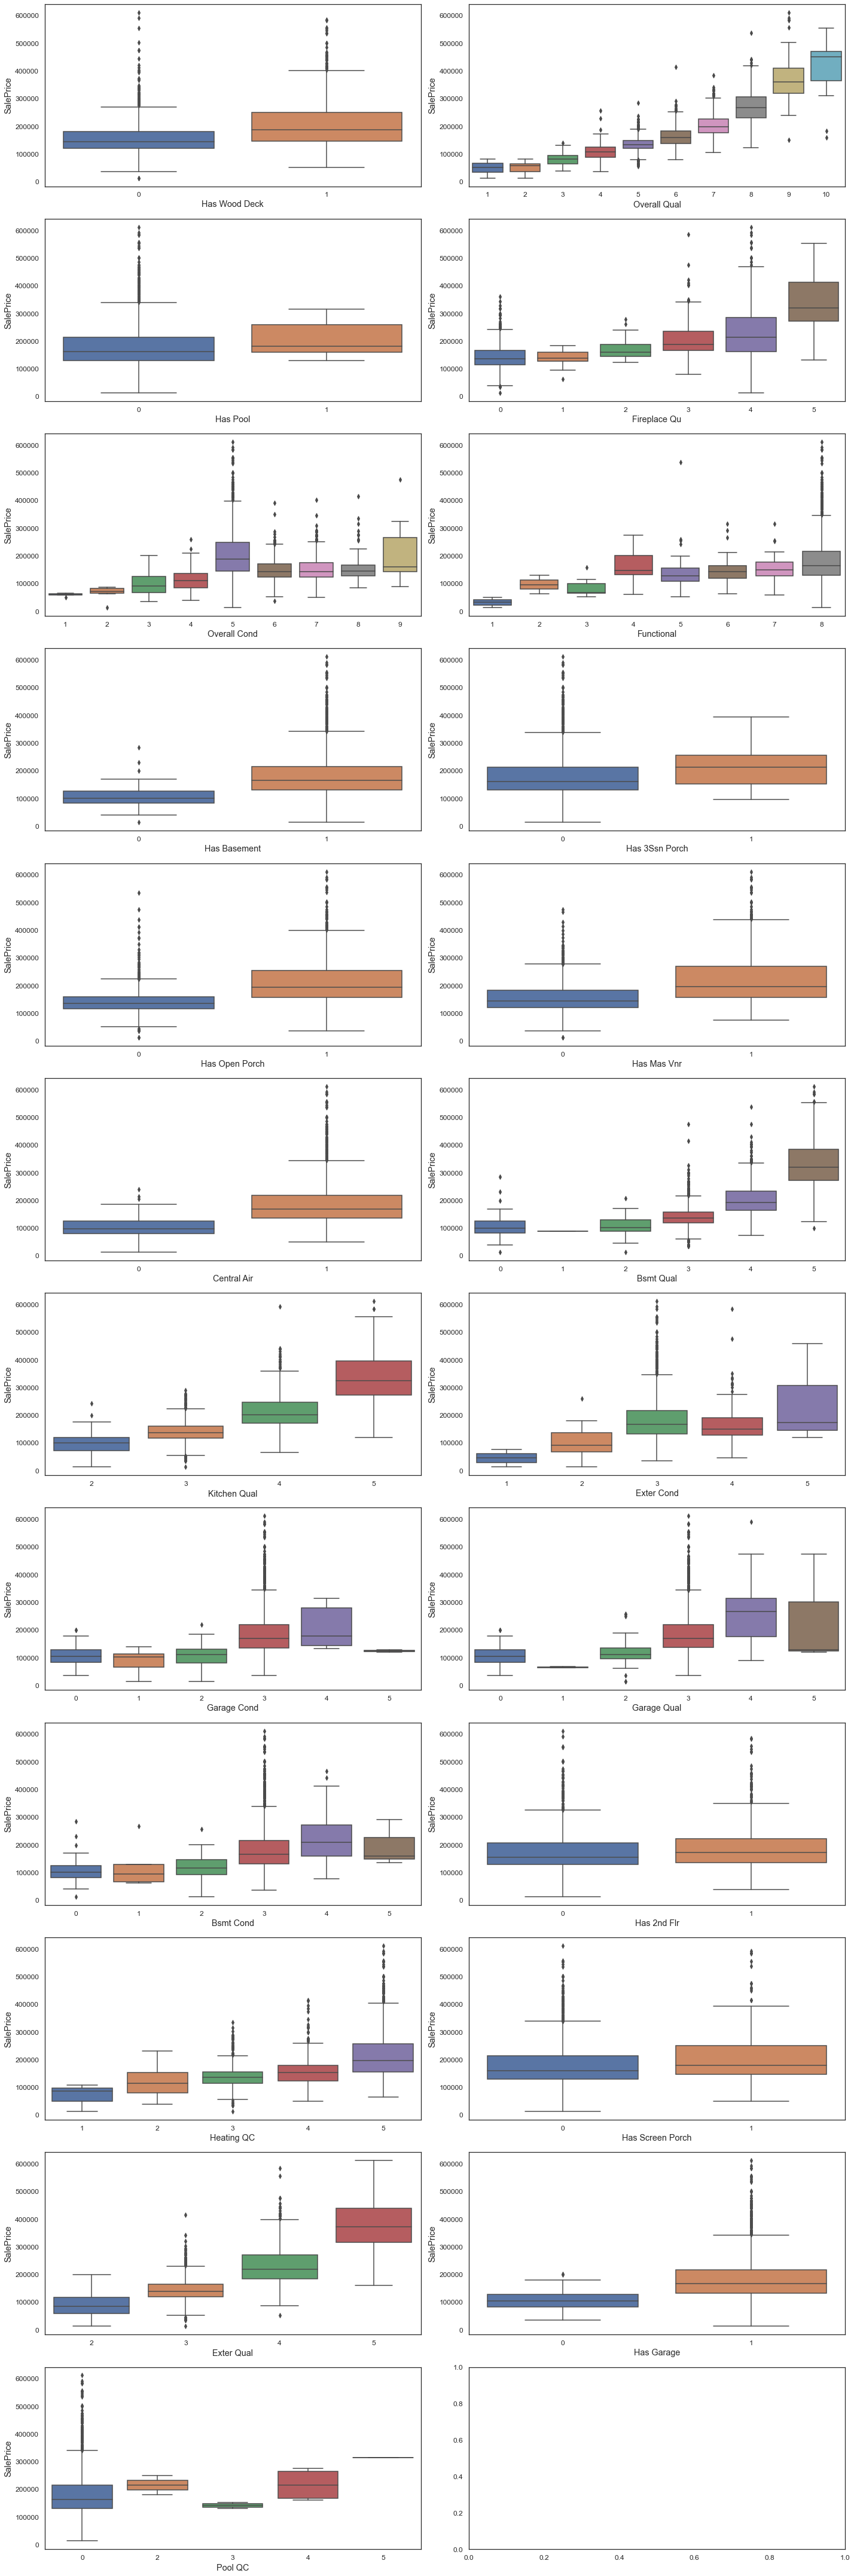

In [1693]:
plot_boxplot(df = ordinal_df_train, features = ordinal_boolean_features, response = "SalePrice", height_multiple = 0.5)

We can see from the boxplots that `Pool QC` is unlikely to have significant impact on `SalePrice`.

For others, we do see some form of difference but could not judge whether they are significant, we will create additional feature sets with different features to drop.

In [1694]:
# Add Pool QC to our original 3 sets of feature names
features_to_drop1 = list(set(features_to_drop1 + ['Pool QC']))
features_to_drop2 = list(set(features_to_drop2 + ['Pool QC']))
features_to_drop3 = list(set(features_to_drop3 + ['Pool QC']))

# Create additional feature sets by additing more columns to drop
features_to_drop4 = list(set(features_to_drop1 + ['Has 2nd Flr', 'Has Screen Porch', 'Has 3Ssn Porch', 'Has Pool']))
features_to_drop5 = list(set(features_to_drop2 + ['Has 2nd Flr', 'Has Screen Porch', 'Has 3Ssn Porch', 'Has Pool']))
features_to_drop6 = list(set(features_to_drop3 + ['Has 2nd Flr', 'Has Screen Porch', 'Has 3Ssn Porch', 'Has Pool']))

print(len(features_to_drop1))
print(len(features_to_drop2))
print(len(features_to_drop3))
print(len(features_to_drop4))
print(len(features_to_drop5))
print(len(features_to_drop6))

12
14
15
16
18
19


#### Categorical Features

We will perform the same type of analysis on the categorical features.

In [1695]:
categorical_df_train = df_original_combined_no_missing[df_original_combined_no_missing["Train/Test"] == "Train"][categorical_features+["SalePrice"]]
categorical_df_train.head()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Electrical,Garage Type,Garage Finish,Paved Drive,Fence,Misc Feature,Sale Type,MS SubClass,Yr Sold,Mo Sold,SalePrice
0,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,Gable,CompShg,HdBoard,Plywood,BrkFace,CBlock,No,GLQ,Unf,GasA,SBrkr,Attchd,RFn,Y,NA,NA,WD,60,2010,3,130500.0
1,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,No,GLQ,Unf,GasA,SBrkr,Attchd,RFn,Y,NA,NA,WD,60,2009,4,220000.0
2,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,No,GLQ,Unf,GasA,SBrkr,Detchd,Unf,Y,NA,NA,WD,20,2010,1,109000.0
3,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,No,Unf,Unf,GasA,SBrkr,BuiltIn,Fin,Y,NA,NA,WD,60,2010,4,174000.0
4,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,Wd Sdng,Plywood,None,PConc,No,Unf,Unf,GasA,SBrkr,Detchd,Unf,N,NA,NA,WD,50,2010,3,138500.0


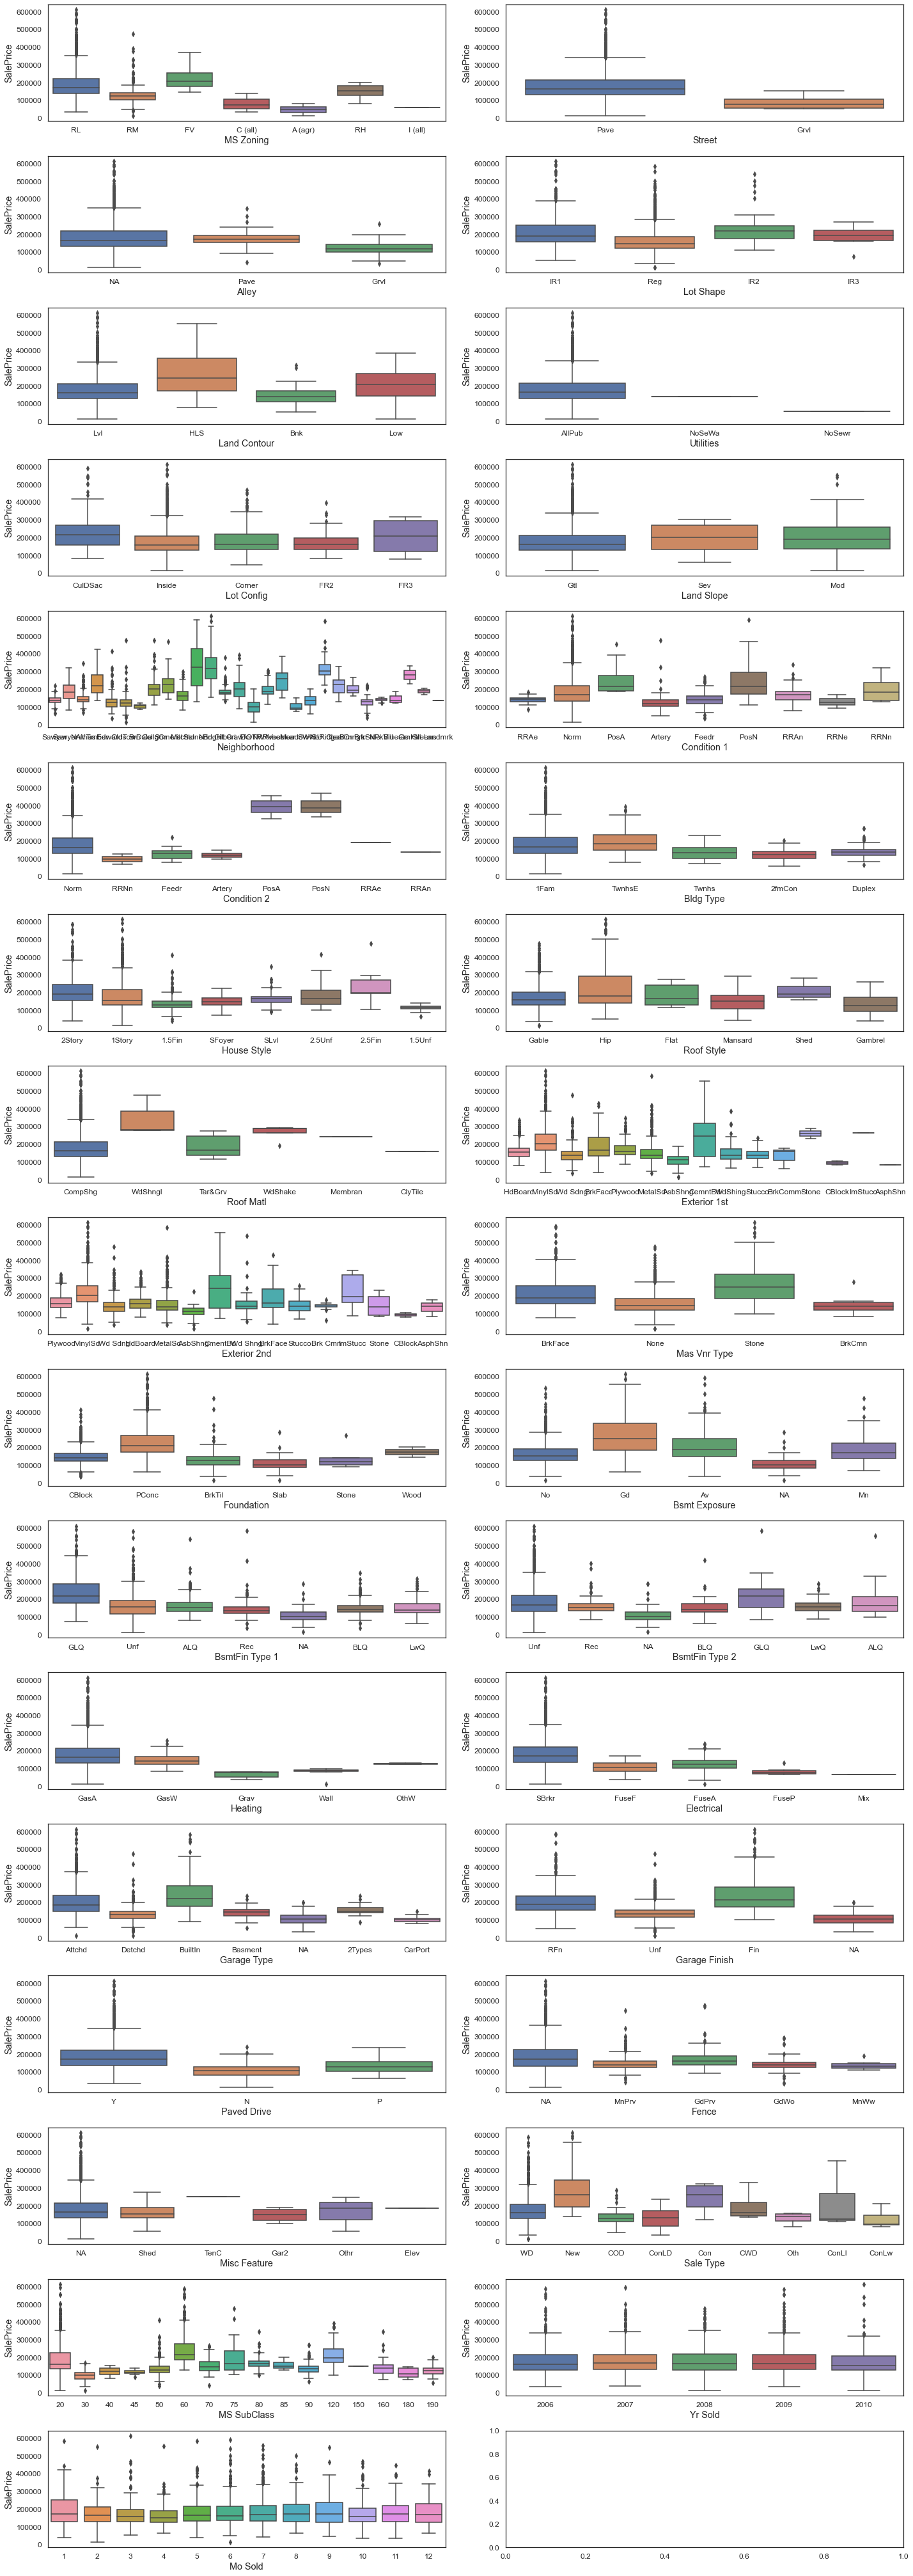

In [1696]:
plot_boxplot(df = categorical_df_train, features = categorical_features, response = "SalePrice", height_multiple = 0.33)

Again, we will add some features to our features to drop sets and create additional feature sets 

In [1697]:
# categorical features we are quite sure has little impact - add to existing drop lists
features_to_drop1, features_to_drop2, features_to_drop3, features_to_drop4, features_to_drop5, features_to_drop6 = add_list_to_lists([features_to_drop1, features_to_drop2, features_to_drop3, features_to_drop4, features_to_drop5, features_to_drop6], 
                  ["Mo Sold", "Yr Sold", "Fence"])

In [1698]:
# categorical features that might have little impact, but we are not sure - create new feature sets
features_to_drop7, features_to_drop8, features_to_drop9, features_to_drop10, features_to_drop11, features_to_drop12 = add_list_to_lists([features_to_drop1, features_to_drop2, features_to_drop3, features_to_drop4, features_to_drop5, features_to_drop6], 
                  ["Alley", "Lot Shape", "Fence", "Lot Config", "Bldg Type", "Roof Style"])

In [1699]:
# categorical features that has too many different unique values, which may result in overfitting
# we add them on top of the previous set of features to drop
features_to_drop13, features_to_drop14, features_to_drop15, features_to_drop16, features_to_drop17, features_to_drop18 = add_list_to_lists([features_to_drop7, features_to_drop8, features_to_drop9, features_to_drop10, features_to_drop11, features_to_drop12], 
                  ["MS SubClass", "Exterior 1st", "Exterior 2nd"])

In [1700]:
print(len(features_to_drop1))
print(len(features_to_drop2))
print(len(features_to_drop3))
print(len(features_to_drop4))
print(len(features_to_drop5))
print(len(features_to_drop6))
print(len(features_to_drop7))
print(len(features_to_drop8))
print(len(features_to_drop9))
print(len(features_to_drop10))
print(len(features_to_drop11))
print(len(features_to_drop12))
print(len(features_to_drop13))
print(len(features_to_drop14))
print(len(features_to_drop15))
print(len(features_to_drop16))
print(len(features_to_drop17))
print(len(features_to_drop18))

15
17
18
19
21
22
20
22
23
24
26
27
23
25
26
27
29
30


#### Other features with a dominant value

We have examined and identified numeric variables with a weak correlation and a high percentage of dominant values, we will now identify ordinal and categorical variables with a high percentage of a single dominant value

In [1701]:
# ordinal and categorical features
categorical_ordinal_features = categorical_features + ordinal_boolean_features
categorical_ordinal_df = df_original_combined_no_missing[df_original_combined_no_missing["Train/Test"] == "Train"][categorical_ordinal_features]

# And get the feature names of those with more than 90% or 80% dominant value
single_val_cat_ord = single_value_percentage(categorical_ordinal_df)
dominant_80 = list(single_val_cat_ord[single_val_cat_ord>0.8].dropna().index)
dominant_90 = list(single_val_cat_ord[single_val_cat_ord>0.9].dropna().index)

In [1702]:
# And create more feature sets to drop
# Because there are many more feature sets now, we will create a dictionary to hold all feature sets
# The first feature set (0) will be an empty set - complete set of features
feature_sets_to_drop = [[], features_to_drop1, features_to_drop2, features_to_drop3, features_to_drop4,
                       features_to_drop5, features_to_drop6, features_to_drop7, features_to_drop8,
                       features_to_drop9, features_to_drop10, features_to_drop11, features_to_drop12,
                       features_to_drop13, features_to_drop14, features_to_drop15, features_to_drop16,
                       features_to_drop17, features_to_drop18]

# feature sets dictionary of current feature sets
feature_sets_to_drop_dict = {f"feature_set_{i}": feature_set for i, feature_set in enumerate(feature_sets_to_drop)}

# add the dominant_80 and dominant_90 features to each of the existing features to drop list 
# and create 24 new feature sets, making a total of 37 sets

# for dominant_80
current_dict_length = len(feature_sets_to_drop_dict) # current length of dict
current_dict_items = list(feature_sets_to_drop_dict.values())
for i, features in enumerate(current_dict_items):
    if features != []:
        feature_sets_to_drop_dict[f"feature_set_{i+current_dict_length}"] = list(set(features + dominant_80))

# for dominant_90
current_dict_length = len(feature_sets_to_drop_dict) # current length of dict
for i, features in enumerate(current_dict_items):
    if features != []:
        feature_sets_to_drop_dict[f"feature_set_{i+current_dict_length}"] = list(set(features + dominant_90))

for i, feature_list in enumerate(feature_sets_to_drop_dict.values()):
    print(f"Feature set {i} length: ", len(feature_list))

Feature set 0 length:  0
Feature set 1 length:  15
Feature set 2 length:  17
Feature set 3 length:  18
Feature set 4 length:  19
Feature set 5 length:  21
Feature set 6 length:  22
Feature set 7 length:  20
Feature set 8 length:  22
Feature set 9 length:  23
Feature set 10 length:  24
Feature set 11 length:  26
Feature set 12 length:  27
Feature set 13 length:  23
Feature set 14 length:  25
Feature set 15 length:  26
Feature set 16 length:  27
Feature set 17 length:  29
Feature set 18 length:  30
Feature set 19 length:  41
Feature set 20 length:  43
Feature set 21 length:  44
Feature set 22 length:  42
Feature set 23 length:  44
Feature set 24 length:  45
Feature set 25 length:  44
Feature set 26 length:  46
Feature set 27 length:  47
Feature set 28 length:  45
Feature set 29 length:  47
Feature set 30 length:  48
Feature set 31 length:  47
Feature set 32 length:  49
Feature set 33 length:  50
Feature set 34 length:  48
Feature set 35 length:  50
Feature set 36 length:  51
Feature set 

## Modelling 

### Pre-processing

We can now start the modelling process with the 13 different features sets (includes base set with all features). First, we obtain dataframes by dropping different numbers of features, then we create dummy variables for categorical variables and re-split our feature sets into train and test.

In [1724]:
# create a dictionary with the the feature set name and the associated dataframe of features

feature_sets = {}
feature_sets_dummy = {}
X_trains = {}
y_trains = {}
X_tests = {}
for i, drop_features in enumerate((feature_sets_to_drop_dict.values())):
    
    # create feature sets by dropping features to drop
    feature_set_name = f"feature_set_{i}" 
    feature_sets[feature_set_name] = df_original_combined_no_missing.drop(drop_features, axis = 1).drop('Id', axis = 1)
    
    # create dummy variables for categorical features
    # get list of features which are categorical
    categorical_var_subset = [col for col in feature_sets[feature_set_name].columns 
                              if col in categorical_features]
    feature_sets_dummy[feature_set_name] = pd.get_dummies(feature_sets[feature_set_name], 
                                                          columns= categorical_var_subset, 
                                                          drop_first=True)
    
    # re-split into train and test sets
    # Train set
    X_trains[feature_set_name] = feature_sets_dummy[feature_set_name][feature_sets_dummy[feature_set_name]["Train/Test"] == 'Train'].drop(["Train/Test", "SalePrice"], axis = 1)
    y_trains[feature_set_name] = feature_sets_dummy[feature_set_name][feature_sets_dummy[feature_set_name]["Train/Test"] == 'Train']['SalePrice']
    
    # Test set
    X_tests[feature_set_name] = feature_sets_dummy[feature_set_name][feature_sets_dummy[feature_set_name]["Train/Test"] == 'Test'].drop(["Train/Test", "SalePrice"], axis = 1)
    
    """print(feature_set_name, "(X_train) shape:", X_trains[feature_set_name].shape)
    print(feature_set_name, "(y_test) shape:", y_trains[feature_set_name].shape)
    print(feature_set_name, "(X_test) shape:", X_tests[feature_set_name].shape)"""

### Model Fitting and Evaluation

#### Round 1 

##### Model Fitting

In [1765]:
"""estimators = {
    "linear": {'estimator':LinearRegression(), 'params': {}}, 
    "ridge": {'estimator': Ridge(), 'params': {"ridge__alpha": np.logspace(-1,5,100)}}, 
    "lasso": {'estimator': Lasso(max_iter = 5000), 'params': {"lasso__alpha": np.logspace(-6,1,10)}}, 
    "enet": {'estimator': ElasticNet(max_iter = 5000), "params": {"enet__alpha": np.linspace(0.5, 1.0, 10), "enet__l1_ratio": np.linspace(0.1, 1, 10)}},
    "knn": {"estimator": KNeighborsRegressor(), "params": {"knn__n_neighbors": [3, 5, 7, 9, 11, 21, 31, 41, 51, 101], "knn__weights": ['uniform', 'distance']}}
}"""

estimators = {
    "linear": {'estimator':LinearRegression(), 'params': {}}, 
    "ridge": {'estimator': Ridge(), 'params': {"ridge__alpha": np.logspace(-1,5,100)}}, 
    "knn": {"estimator": KNeighborsRegressor(), "params": {"knn__n_neighbors": [3, 5, 7, 9, 11, 21, 31, 41, 51, 101], "knn__weights": ['uniform', 'distance']}}
}

grid_search_result = []
# loop through all feature sets, then loop through selected estimators and run pipeline
for i, feature_set in enumerate(X_trains.items()):
    num_features = X_trains[f"feature_set_{i}"].shape[1]
    print(f"------------------------ Feature set {i} - no. of features: {num_features} ------------------------")
    grid_search_result_row = {}
    for estimator_name, estimator_info in estimators.items():
        #print(f"{estimator_name}------------------------------------------------------------------")
        #print()
        pipe = Pipeline([
            ("ss", StandardScaler()),
            (estimator_name, estimator_info['estimator'])
        ])
        pipe_params = estimator_info['params']
        pipe_gridsearch = GridSearchCV(pipe,
                                      pipe_params,
                                      cv = 5,
                                      verbose = 0,
                                      scoring = "neg_root_mean_squared_error",
                                      n_jobs = 6)
        pipe_gridsearch.fit(X_trains[f"feature_set_{i}"], y_trains[f"feature_set_{i}"])
        print(f"{estimator_name} score:", -pipe_gridsearch.best_score_)
        
        # add estimator and score into a dictionary
        grid_search_result_row["feature_set"] = f"feature_set_{i}"
        grid_search_result_row["num of features"] = X_trains[f"feature_set_{i}"].shape[1]
        grid_search_result_row[f"{estimator_name}: grid search object"] = pipe_gridsearch
        grid_search_result_row[f"{estimator_name}: best estimator"] = pipe_gridsearch.best_estimator_
        grid_search_result_row[f"{estimator_name}: best score"] = -(pipe_gridsearch.best_score_)
        grid_search_result_row[f"{estimator_name}: best params"] = pipe_gridsearch.best_params_
    
    grid_search_result.append(grid_search_result_row)

        

------------------------ Feature set 0 - no. of features: 271 ------------------------
linear score: 1.5704735843312e+17
ridge score: 28796.20132102826
knn score: 36424.10165097444
------------------------ Feature set 1 - no. of features: 240 ------------------------
linear score: 5.428710714426016e+16
ridge score: 28450.36708311989
knn score: 36396.05926655551
------------------------ Feature set 2 - no. of features: 238 ------------------------
linear score: 3.9969891944196883e+17
ridge score: 28525.67072698986
knn score: 36117.08808830096
------------------------ Feature set 3 - no. of features: 237 ------------------------
linear score: 1.660180012861722e+17
ridge score: 28511.055522812403
knn score: 36256.77544541735
------------------------ Feature set 4 - no. of features: 236 ------------------------
linear score: 1.8035323206522806e+17
ridge score: 28242.22223879277
knn score: 36243.93603175904
------------------------ Feature set 5 - no. of features: 234 ----------------------

knn score: 36597.324412837275
------------------------ Feature set 45 - no. of features: 176 ------------------------
linear score: 4.32789523520468e+16
ridge score: 28761.56195886896
knn score: 36610.13998418917
------------------------ Feature set 46 - no. of features: 178 ------------------------
linear score: 4.106844888209035e+16
ridge score: 28502.71440105985
knn score: 36638.52346457225
------------------------ Feature set 47 - no. of features: 176 ------------------------
linear score: 6497767775497454.0
ridge score: 28766.943304076987
knn score: 36509.333705509285
------------------------ Feature set 48 - no. of features: 175 ------------------------
linear score: 364536101166267.75
ridge score: 28755.27612408432
knn score: 36535.392470889245
------------------------ Feature set 49 - no. of features: 133 ------------------------
linear score: 1836892483665357.5
ridge score: 29601.825801049104
knn score: 36119.39087838268
------------------------ Feature set 50 - no. of feature

##### Model Evaluation

In [1792]:
# print out the sorted df with the result from the gridcv
gridsearch_result_df = pd.DataFrame(grid_search_result)
gridsearch_result_df.head()

,feature_set,num of features,linear: grid search object,linear: best estimator,linear: best score,linear: best params,ridge: grid search object,ridge: best estimator,ridge: best score,ridge: best params,knn: grid search object,knn: best estimator,knn: best score,knn: best params
0,feature_set_0,271,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",1.570474e+17,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=432.87612810830...",28796.201321,{'ridge__alpha': 432.87612810830615},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36424.101651,"{'knn__n_neighbors': 11, 'knn__weights': 'dist..."
1,feature_set_1,240,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",5.428711e+16,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=247.70763559917...",28450.367083,{'ridge__alpha': 247.70763559917114},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36396.059267,"{'knn__n_neighbors': 9, 'knn__weights': 'dista..."
2,feature_set_2,238,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",3.996989e+17,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=247.70763559917...",28525.670727,{'ridge__alpha': 247.70763559917114},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36117.088088,"{'knn__n_neighbors': 9, 'knn__weights': 'dista..."
3,feature_set_3,237,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",1.660180e+17,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=247.70763559917...",28511.055523,{'ridge__alpha': 247.70763559917114},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36256.775445,"{'knn__n_neighbors': 9, 'knn__weights': 'dista..."
4,feature_set_4,236,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",1.803532e+17,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=215.44346900318...",28242.222239,{'ridge__alpha': 215.44346900318845},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36243.936032,"{'knn__n_neighbors': 9, 'knn__weights': 'dista..."


In [1793]:
gridsearch_result_df_normalized = normalize_values_columns(gridsearch_result_df, ["linear: best score", "ridge: best score", "knn: best score"])

In [1794]:
# Top feature sets by mean normalized score
gridsearch_result_df_normalized["mean normalized score"] = (gridsearch_result_df_regularized["knn: best score (normalized)"] + gridsearch_result_df_regularized["ridge: best score (normalized)"]+ gridsearch_result_df_regularized["linear: best score (normalized)"]) / 3
gridsearch_result_df_normalized.sort_values(by = "mean normalized score").head()

,feature_set,num of features,linear: grid search object,linear: best estimator,linear: best score,linear: best params,ridge: grid search object,ridge: best estimator,ridge: best score,ridge: best params,knn: grid search object,knn: best estimator,knn: best score,knn: best params,linear: best score (normalized),ridge: best score (normalized),knn: best score (normalized),mean normalized score
28,feature_set_28,149,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",6.986860e+14,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=141.74741629268...",28696.074671,{'ridge__alpha': 141.74741629268047},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",35567.968189,"{'knn__n_neighbors': 7, 'knn__weights': 'dista...",0.000542,0.229910,0.573005,0.257164
25,feature_set_25,150,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",7.098807e+15,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=141.74741629268...",28700.906374,{'ridge__alpha': 141.74741629268047},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",35619.117217,"{'knn__n_neighbors': 7, 'knn__weights': 'dista...",0.005510,0.232358,0.589432,0.265081
34,feature_set_34,103,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",2.194323e+12,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=215.44346900318...",29873.403114,{'ridge__alpha': 215.44346900318845},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",33783.713336,"{'knn__n_neighbors': 7, 'knn__weights': 'dista...",0.000002,0.826314,0.000000,0.270068
31,feature_set_31,104,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",2.433113e+12,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=215.44346900318...",29882.766794,{'ridge__alpha': 215.44346900318845},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(weights...",33897.136922,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.000002,0.831058,0.036425,0.284537
29,feature_set_29,147,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",4.552631e+16,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=141.74741629268...",28964.504066,{'ridge__alpha': 141.74741629268047},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(weights...",35244.185474,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.035340,0.365889,0.469024,0.288645


In [1795]:
# Top feature sets by ridge score
gridsearch_result_df_normalized.sort_values(by = "ridge: best score").head()

,feature_set,num of features,linear: grid search object,linear: best estimator,linear: best score,linear: best params,ridge: grid search object,ridge: best estimator,ridge: best score,ridge: best params,knn: grid search object,knn: best estimator,knn: best score,knn: best params,linear: best score (normalized),ridge: best score (normalized),knn: best score (normalized),mean normalized score
4,feature_set_4,236,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",1.803532e+17,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=215.44346900318...",28242.222239,{'ridge__alpha': 215.44346900318845},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36243.936032,"{'knn__n_neighbors': 9, 'knn__weights': 'dista...",0.140002,0.000000,0.790089,0.310030
10,feature_set_10,218,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",2.620503e+17,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=141.74741629268...",28301.220570,{'ridge__alpha': 141.74741629268047},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36778.201045,"{'knn__n_neighbors': 9, 'knn__weights': 'dista...",0.203421,0.029887,0.961666,0.436252
40,feature_set_40,194,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",9.063775e+14,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=215.44346900318...",28413.533022,{'ridge__alpha': 215.44346900318845},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36247.918640,"{'knn__n_neighbors': 9, 'knn__weights': 'dista...",0.000704,0.086782,0.791368,0.297680
37,feature_set_37,195,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",7.766542e+15,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=215.44346900318...",28421.850399,{'ridge__alpha': 215.44346900318845},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36313.318504,"{'knn__n_neighbors': 11, 'knn__weights': 'dist...",0.006029,0.090995,0.812371,0.308064
1,feature_set_1,240,"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), LinearRegression())",5.428711e+16,{},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), Ridge(alpha=247.70763559917...",28450.367083,{'ridge__alpha': 247.70763559917114},"GridSearchCV(cv=5,\n estimator=Pip...","(StandardScaler(), KNeighborsRegressor(n_neigh...",36396.059267,"{'knn__n_neighbors': 9, 'knn__weights': 'dista...",0.042141,0.105441,0.838943,0.321418


In [1798]:
# DataFrame with just scores and plot a line plot of different scores and 
gridsearch_result_just_scores = gridsearch_result_df[["feature_set", "num of features", "linear: best score", "ridge: best score", "knn: best score", "linear: best score (normalized)", "ridge: best score (normalized)", "knn: best score (normalized)", "mean normalized score"]]
gridsearch_result_just_scores.head()

,feature_set,num of features,linear: best score,ridge: best score,knn: best score,linear: best score (normalized),ridge: best score (normalized),knn: best score (normalized),mean normalized score
0,feature_set_0,271,1.570474e+17,28796.201321,36424.101651,0.121910,0.280632,0.847949,0.376770
1,feature_set_1,240,5.428711e+16,28450.367083,36396.059267,0.042141,0.105441,0.838943,0.321418
2,feature_set_2,238,3.996989e+17,28525.670727,36117.088088,0.310272,0.143588,0.749353,0.394052
3,feature_set_3,237,1.660180e+17,28511.055523,36256.775445,0.128874,0.136184,0.794213,0.346765
4,feature_set_4,236,1.803532e+17,28242.222239,36243.936032,0.140002,0.000000,0.790089,0.310030


In [1806]:
gridsearch_result_just_scores_long = gridsearch_result_just_scores.drop(["linear: best score", "ridge: best score", "knn: best score"], axis = 1).melt(id_vars = ["feature_set", "num of features"])
gridsearch_result_just_scores_long.head()

,feature_set,num of features,variable,value
215,feature_set_50,131,mean normalized score,0.535831
216,feature_set_51,130,mean normalized score,0.541042
217,feature_set_52,132,mean normalized score,0.477041
218,feature_set_53,130,mean normalized score,0.520685
219,feature_set_54,129,mean normalized score,0.523540


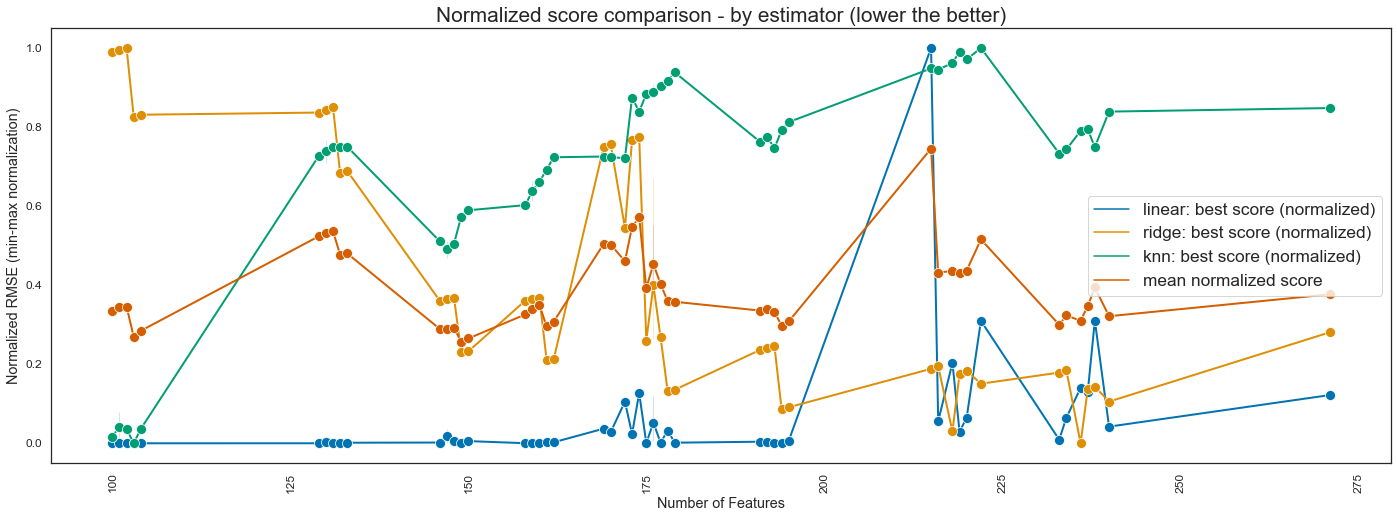

In [1893]:
# By number of features
plt.figure(figsize = (24, 8))
sns.lineplot(x="num of features", y="value", hue = "variable", 
             data=gridsearch_result_just_scores_long, 
             palette='colorblind', marker = 'o', markersize = 10, linewidth = 2);
plt.xticks(rotation = 90);
plt.title("Normalized score comparison - by estimator (lower the better)")
plt.ylabel("Normalized RMSE (min-max normalization)")
plt.xlabel("Number of Features")
plt.legend(loc = 'best')
#plt.tight_layout()

<Figure size 1728x864 with 0 Axes>

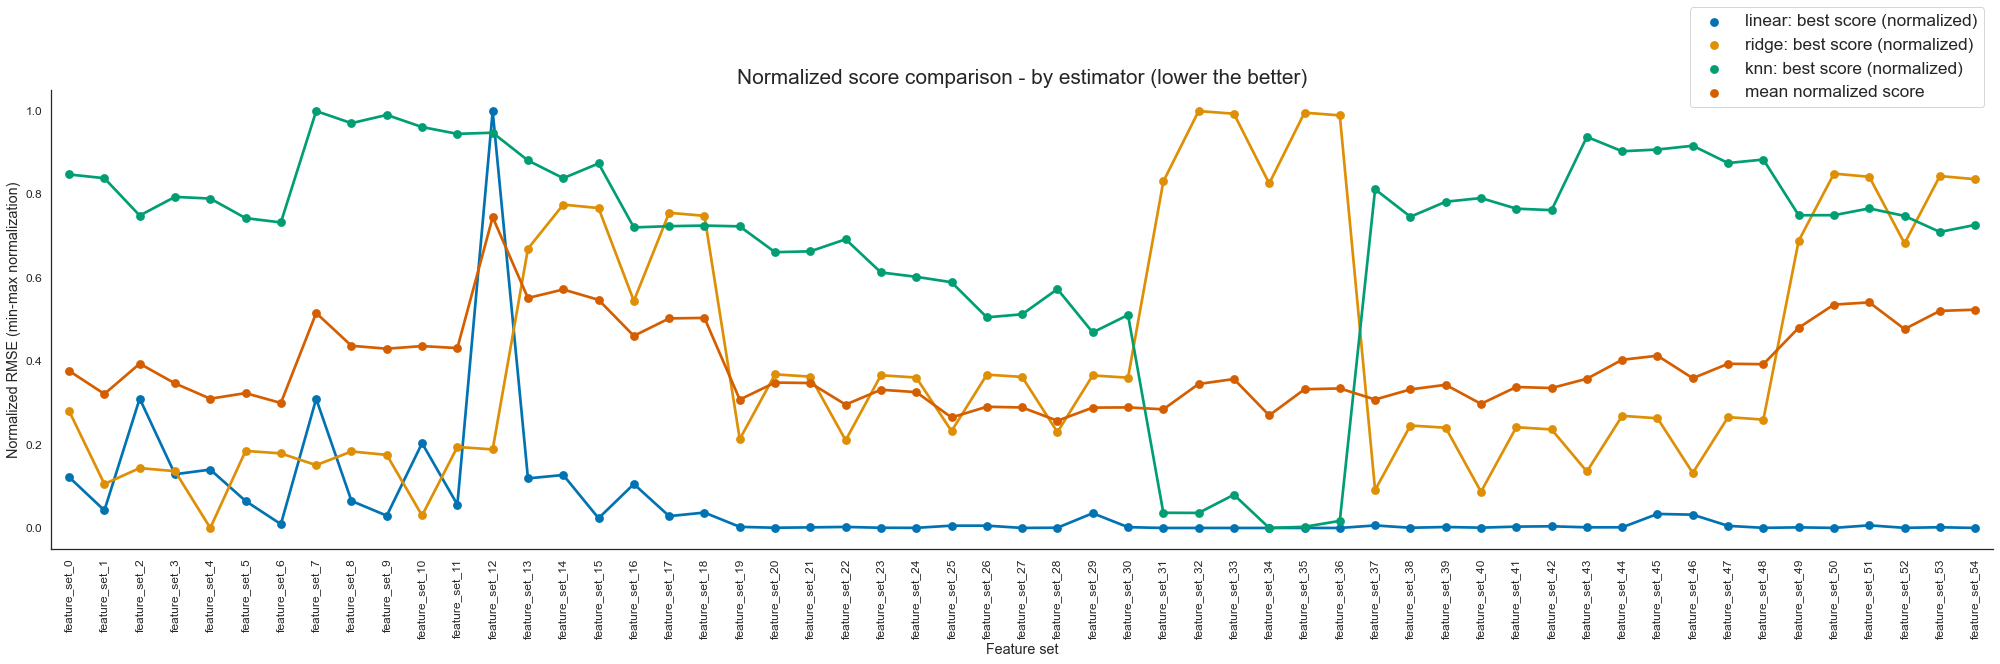

In [1884]:
# By feature set index
plt.figure(figsize = (24, 12))
g = sns.catplot(x="feature_set", y="value", hue = "variable", data=gridsearch_result_just_scores_long, 
                kind='point', palette='colorblind', aspect = 4, height = 7, legend = None);
plt.xticks(rotation = 90);
plt.title("Normalized score comparison - by estimator (lower the better)")
plt.ylabel("Normalized RMSE (min-max normalization)")
plt.xlabel("Feature set")
plt.legend(loc = 'upper right', bbox_to_anchor=(1,1.2));
#plt.tight_layout()

### Model Interpretation

#### Top 10 Most important features with positive impact on Sale Price

In [1781]:
# Get coefficients 
best_estimator_coef = pd.Series(grid_search_result[4]["ridge: best estimator"][1].coef_, name = "Coefficients")
best_estimator_features = pd.Series(X_trains["feature_set_4"].columns, name = "Features")
results_df = pd.DataFrame([best_estimator_coef, best_estimator_features]).T.sort_values(by = "Coefficients", ascending=False)
results_df.head(13)

,Coefficients,Features
3,9640.76,Overall Qual
99,8691.35,Neighborhood_NridgHt
16,8268.64,Gr Liv Area
139,6315.69,Roof Matl_CompShg
105,6257.6,Neighborhood_StoneBr
22,5736.54,Kitchen Qual
37,5695.91,Gross Flr Area
27,5694.99,Garage Area
14,5309.59,1st Flr SF
6,4833.15,Exter Qual


#### Top 10 Most important features with negative impact on Sale Price

In [1782]:
results_df.tail(10)

,Coefficients,Features
218,-2441.23,Garage Finish_RFn
34,-2694.35,Age Since Built
68,-2718.25,Lot Shape_IR3
95,-2764.05,Neighborhood_NAmes
189,-2925.74,Bsmt Exposure_No
55,-2957.83,MS SubClass_160
125,-3072.66,Bldg Type_Twnhs
126,-3338.26,Bldg Type_TwnhsE
87,-3532.64,Neighborhood_Edwards
53,-4041.45,MS SubClass_120


In [1907]:
def positive_or_negative(row):
    if row["Coefficients"] >0:
        row["Impact"] = "Positive Impact"
    else:
        row["Impact"] = "Negative Impact"
    return row
    
results_df_most_impt = pd.concat([results_df.head(13), results_df.tail(10)])

results_df_most_impt = results_df_most_impt.apply(positive_or_negative, axis = 1)
results_df_most_impt.tail()

,Coefficients,Features,Impact
55,-2957.829047,MS SubClass_160,Negative Impact
125,-3072.659205,Bldg Type_Twnhs,Negative Impact
126,-3338.262403,Bldg Type_TwnhsE,Negative Impact
87,-3532.639290,Neighborhood_Edwards,Negative Impact
53,-4041.446824,MS SubClass_120,Negative Impact


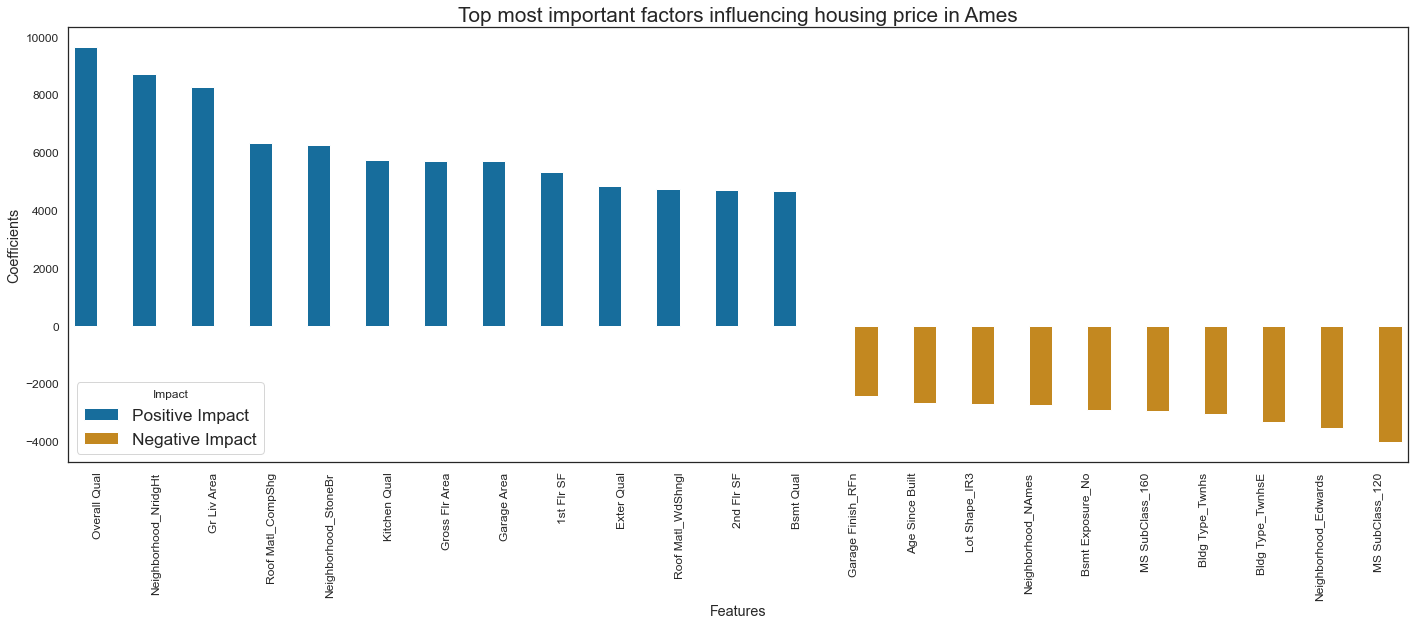

In [1906]:
plt.figure(figsize = (24, 8))
sns.barplot(data = results_df_most_impt, x = "Features", y = "Coefficients",
           hue = "Impact", palette='colorblind')
plt.xticks(rotation = 90)
plt.title("Top most important factors influencing housing price in Ames");

Here, we can easily visualize the most important factors having an impact on sale price, grouped by positive and negative impact.

## Conclusions and Recommendations

We see that the most important features influencing sale price can be grouped in a few categories:
- Quality:
    - in terms of quality, we see that other than the `Overall Qual`, the most important quality features influencing sale price are `Kitchen Qual` and `Exterior Qual`
- Neighbourhood:
    - you should get a property in `Northridge Heights` and `Stone Brook`, try to avoid neighborhoods in `North Ames` and `Edwards`
- Area
    - The bigger the `overall above grade area`, the better, `first floor area` is more important than `second floor area`, the `basement area` is not as important (but `basement quality` can be quite important)
- Roof Material
    - An often overlooked factor is perhaps the roofing material, pick `Wood Shingles` if you want to fetch a higher price
- Type of dwelling
    - Avoid `1-STORY` and `2-STORY PUD (Planned Unit Development)`
- Building Type
    - Avoid `Townhouses`
- Basement
    - `Basement Quality` over area
    - `Basements with no exposure` generallly fetches lower price
- Lot Shape
    - `Irregular plots` fetches lower price
- Age of house
    - Oler houses fetch lower price
- Garage finish
    - Garages with rough finish fetch lower prices

## Submission

In [1908]:
# scaling of test set 
X_test_scaled = grid_search_result[4]["ridge: best estimator"][0].transform(X_tests["feature_set_4"])

In [1909]:
prediction = grid_search_result[4]["ridge: best estimator"][1].predict(X_test_scaled)
prediction_proper = pd.concat([df_original_test["Id"].reset_index(), pd.Series(prediction, name = "SalePrice")], axis = 1)
prediction_proper = prediction_proper.drop("index", axis = 1)
prediction_proper

,Id,SalePrice
0,2,128038.738651
1,4,262564.826008
2,6,191379.581937
3,7,240797.735112
4,17,201792.225281
...,...,...
873,2919,66984.711783
874,2921,75028.610027
875,2922,174563.034076
876,2925,172900.663341


In [1910]:
# export prediction
#prediction_proper.to_csv("../datasets/submission.csv", index = None)

Kaggle Score:
 ![Kaggle score](../assets/kaggle_submission_dataset4_20220202.png)